#### LSE Data Analytics Online Career Accelerator
#### Course 2: Data Analytics using Python - Mirasha Perera

# NHS - Diagnostic Analysis using Python

#### The NHS must expand its infrastructure and resources to match its increasing population capacity. For this, it needs to budget correctly. When deciding on budget allotment, the NHS must understand the utilisation trends of each component in its network.

- Has there been adequate staff and capacity in the networks?
- What was the actual utilisation of resources?


## 1.0 Import Libraries

In [3]:
# Import the necessary libraries.
import pandas as pd
import numpy as np
from io import StringIO 
import matplotlib.pyplot as plt
import seaborn as sns

# Import necessary libraries to get data from SQL database.
import requests
import os
from sqlalchemy import create_engine
from sqlalchemy import inspect

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# Enable SQL extension
%load_ext sql


## 2.0 Define Functions

In [4]:
# Function to Validate data.
def validate_data(df):
    """ 
    This function returns the data types,meta data and duplicates
    """  
    # Check Data Types.
    data_types=df.dtypes
    print("Data Types:")
    print(data_types)
    
    # View Metadata.
    print("\nreview metadata:")
    data_info = df.info()
    
    # Duplicate check.
    duplicates= df.duplicated().sum()
    print("\nNumber of duplicates:")
    print(duplicates)
    
    return data_types, data_info, duplicates


# Function to group and aggregate data.
def group_agg_sort_reset (df,category,agg_col,num_rows,sort=True):
    """
    This function groups and aggregates the provided data, and optionally sorts the result by the aggregated column in descending order. 
    It then converts the result to a dataframe. If num_rows is provided, only the specified number of rows will be returned in the dataframe.
    """
    if sort:
        sorted_df = df.groupby(category)[agg_col].sum().sort_values(ascending=False).reset_index()
        if num_rows is None:
            return sorted_df
        else:
            return sorted_df.head(num_rows)
    else:
        grouped_df =df.groupby(category)[agg_col].sum().reset_index()
        if num_rows is None:
            return grouped_df
        else:
            return grouped_df.head(num_rows)
        
    

# Calculate percentage.
def percentage (df,col,total):
    total_perecent = ((df[col]/total)*100).round(2)
    return total_perecent


# Function to get the min-max dates.
def min_max_dates(df):
    x = df['appointment_date'].dt.date.min()
    y = df['appointment_date'].dt.date.max()
    return x,y

# Function to get the min-max months.
def min_max_months(df):
    x = df['appointment_month'].min()
    y = df['appointment_month'].max()
    return x,y

#Formatted bar chart

def formatted_barplot(data, x, y, title, xlabel, ylabel, xtick_rotation,color):
    """
    This function creates a bar plot using seaborn library.
    
    Parameters:
        df: The input dataframe.
        x: The column name for the x-axis.
        y: The column name for the y-axis.
        title: The title of the plot.
        xlabel: The label for the x-axis.
        ylabel: The label for the y-axis.
        color: The color of the bars.
    """
    plt.figure(figsize=(10, 5))
    sns.barplot(x=x, y=y, data=data, color=color, ci=None)
    
    # Formattings
    plt.title(title, x=0.5, y=1.02, fontsize=16, fontweight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontweight='bold')
    plt.xticks(rotation=xtick_rotation)
    plt.tight_layout()
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    

    


 #Formatted line chart
def formatted_lineplot(data, x, y, title, xlabel, ylabel, hue,xtick_rotation,
                       legend_title,bbox=(1.27,1.02),loc='upper right',frameon=False,hue_order=None,figsize=(13,7)):
    """
    This function creates a line plot using seaborn library.
    
    Parameters:
        df: The input dataframe.
        x: The column name for the x-axis.
        y: The column name for the y-axis.
        hue: The column name for the hue.
        title: The title of the plot.
        xlabel: The label for the x-axis.
        ylabel: The label for the y-axis
        xtick_rotation: The rotation angle of x-axis ticks.
    """
    plt.figure(figsize=(figsize))
    sns.lineplot(data=data, x=x,y=y,hue=hue,ci=None,hue_order=hue_order)

        
    # Update labels and titles
    plt.title(title, x=0.5, y=1.02, fontsize=16, fontweight='bold')
    plt.xlabel(xlabel, fontweight='bold')
    plt.ylabel(ylabel, fontweight='bold')
    plt.xticks(rotation=xtick_rotation)
    
    #Format legend
    plt.legend(loc=loc,title=legend_title,bbox_to_anchor=bbox,frameon=frameon)
    
    # User-defined function to split the months by season
    

def seasonal_data(df, month_col, input_season):
    seasons_dict = {
        'summer': ['06', '07', '08'],
        'autumn': ['09', '10', '11'],
        'winter': ['12', '01', '02'],
        'spring': ['03', '04', '05']}
    target_month = seasons_dict.get(input_season.lower())
    month = df[df[month_col].str[5:7].isin(target_month)]
    return month

## 3.0 Load Data

In [5]:
# Import the provided datasets.
ar_raw = pd.read_csv('appointments_regional.csv')
nc_raw = pd.read_excel('national_categories.xlsx')
ad_raw = pd.read_csv('actual_duration.csv')
tweets = pd.read_csv('tweets.csv')

In [6]:
# Sense check ad_raw dataset.
ad_raw.head()

,sub_icb_location_code,sub_icb_location_ons_code,sub_icb_location_name,icb_ons_code,region_ons_code,appointment_date,actual_duration,count_of_appointments
0,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,01-Dec-21,31-60 Minutes,364
1,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,01-Dec-21,21-30 Minutes,619
2,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,01-Dec-21,6-10 Minutes,1698
3,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,01-Dec-21,Unknown / Data Quality,1277
4,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,01-Dec-21,16-20 Minutes,730


In [7]:
# Sense check ar_raw dataset.
ar_raw.head()

,icb_ons_code,appointment_month,appointment_status,hcp_type,appointment_mode,time_between_book_and_appointment,count_of_appointments
0,E54000034,2020-01,Attended,GP,Face-to-Face,1 Day,8107
1,E54000034,2020-01,Attended,GP,Face-to-Face,15 to 21 Days,6791
2,E54000034,2020-01,Attended,GP,Face-to-Face,2 to 7 Days,20686
3,E54000034,2020-01,Attended,GP,Face-to-Face,22 to 28 Days,4268
4,E54000034,2020-01,Attended,GP,Face-to-Face,8 to 14 Days,11971


In [8]:
# Sense check nc_raw dataset.
nc_raw.head()

,appointment_date,icb_ons_code,sub_icb_location_name,service_setting,context_type,national_category,count_of_appointments,appointment_month
0,2021-08-02,E54000050,NHS North East and North Cumbria ICB - 00L,Primary Care Network,Care Related Encounter,Patient contact during Care Home Round,3,2021-08
1,2021-08-02,E54000050,NHS North East and North Cumbria ICB - 00L,Other,Care Related Encounter,Planned Clinics,7,2021-08
2,2021-08-02,E54000050,NHS North East and North Cumbria ICB - 00L,General Practice,Care Related Encounter,Home Visit,79,2021-08
3,2021-08-02,E54000050,NHS North East and North Cumbria ICB - 00L,General Practice,Care Related Encounter,General Consultation Acute,725,2021-08
4,2021-08-02,E54000050,NHS North East and North Cumbria ICB - 00L,General Practice,Care Related Encounter,Structured Medication Review,2,2021-08


In [9]:
tweets.head()

,tweet_id,tweet_full_text,tweet_entities,tweet_entities_hashtags,tweet_metadata,tweet_retweet_count,tweet_favorite_count,tweet_favorited,tweet_retweeted,tweet_lang
0,1567629223795527681,As Arkansas’ first Comprehensive Stroke Certif...,"{'hashtags': [{'text': 'Healthcare', 'indices'...",#Healthcare,"{'iso_language_code': 'en', 'result_type': 're...",0,0,False,False,en
1,1567582846612553728,RT @AndreaGrammer: Work-life balance is at the...,"{'hashtags': [{'text': 'PremiseHealth', 'indic...","#PremiseHealth, #hiring","{'iso_language_code': 'en', 'result_type': 're...",2,0,False,False,en
2,1567582787070304256,RT @OntarioGreens: $10 billion can go a long w...,"{'hashtags': [{'text': 'Healthcare', 'indices'...",#Healthcare,"{'iso_language_code': 'en', 'result_type': 're...",39,0,False,False,en
3,1567582767625428992,RT @modrnhealthcr: 🚨#NEW:🚨 Insurance companies...,"{'hashtags': [{'text': 'NEW', 'indices': [20, ...",#NEW,"{'iso_language_code': 'en', 'result_type': 're...",5,0,False,False,en
4,1567582720460570625,ICYMI: Our recent blogs on Cybersecurity in Ac...,"{'hashtags': [{'text': 'blogs', 'indices': [18...","#blogs, #digitaltransformation, #cybersecurity...","{'iso_language_code': 'en', 'result_type': 're...",0,0,False,False,en


### 3.1 Additional data source: Import ICB Names and Regional Codes

In [10]:
# Building a connection to get tables from NHS database i've created in PostgreSQL.
# Specify the postgreSQL logins.
host = 'localhost'
database='NHS'
user='postgres'
password='Pass123'

#Create a variable to store the connection request.
connection_string = f"postgresql://{user}:{password}@{host}/{database}"
    
%sql $connection_string

# Name the engine.
engine = create_engine(connection_string)

# Inspect the engine.
inspect = inspect(engine)

# Get table names.
inspect.get_table_names()

['icb_code_names', 'region_names', 'icb_region_names']

In [11]:
# Import the SQL Table as a DF.
icb_region_names = pd.read_sql('SELECT * FROM "icb_region_names"',engine)

# Check whether icb_code_names DF imported correctly.
icb_region_names.head()


,sub_icb_location_ons_code,sub_icb_location_code,sub_icb_location_name,icb_ons_code,icb_location_code,icb_location_name,region_ons_code,region_location_code,region_name
0,E38000006,02P,NHS South Yorkshire ICB - 02P,E54000061,QF7,NHS South Yorkshire ICB,E40000012,Y63,North East and Yorkshire
1,E38000007,99E,NHS Mid and South Essex ICB - 99E,E54000026,QH8,NHS Mid and South Essex ICB,E40000007,Y61,East of England
2,E38000008,02Q,NHS Nottingham and Nottinghamshire ICB - 02Q,E54000060,QT1,NHS Nottingham and Nottinghamshire ICB,E40000011,Y60,Midlands
3,E38000014,00Q,NHS Lancashire and South Cumbria ICB - 00Q,E54000048,QE1,NHS Lancashire and South Cumbria ICB,E40000010,Y62,North West
4,E38000015,00R,NHS Lancashire and South Cumbria ICB - 00R,E54000048,QE1,NHS Lancashire and South Cumbria ICB,E40000010,Y62,North West


## 4.0 Data Validation

In [12]:
# Validate ad_raw dataset.
validate_data(ad_raw)

Data Types:
sub_icb_location_code        object
sub_icb_location_ons_code    object
sub_icb_location_name        object
icb_ons_code                 object
region_ons_code              object
appointment_date             object
actual_duration              object
count_of_appointments         int64
dtype: object

review metadata:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137793 entries, 0 to 137792
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   sub_icb_location_code      137793 non-null  object
 1   sub_icb_location_ons_code  137793 non-null  object
 2   sub_icb_location_name      137793 non-null  object
 3   icb_ons_code               137793 non-null  object
 4   region_ons_code            137793 non-null  object
 5   appointment_date           137793 non-null  object
 6   actual_duration            137793 non-null  object
 7   count_of_appointments      137793 non-null  int64

(sub_icb_location_code        object
 sub_icb_location_ons_code    object
 sub_icb_location_name        object
 icb_ons_code                 object
 region_ons_code              object
 appointment_date             object
 actual_duration              object
 count_of_appointments         int64
 dtype: object,
 None,
 0)

In [13]:
# Validate ar_raw dataset.
validate_data(ar_raw)

Data Types:
icb_ons_code                         object
appointment_month                    object
appointment_status                   object
hcp_type                             object
appointment_mode                     object
time_between_book_and_appointment    object
count_of_appointments                 int64
dtype: object

review metadata:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596821 entries, 0 to 596820
Data columns (total 7 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   icb_ons_code                       596821 non-null  object
 1   appointment_month                  596821 non-null  object
 2   appointment_status                 596821 non-null  object
 3   hcp_type                           596821 non-null  object
 4   appointment_mode                   596821 non-null  object
 5   time_between_book_and_appointment  596821 non-null  object
 6   count_of_appointments

(icb_ons_code                         object
 appointment_month                    object
 appointment_status                   object
 hcp_type                             object
 appointment_mode                     object
 time_between_book_and_appointment    object
 count_of_appointments                 int64
 dtype: object,
 None,
 21604)

In [14]:
# Validate nc_raw dataset.
validate_data(nc_raw)

Data Types:
appointment_date         datetime64[ns]
icb_ons_code                     object
sub_icb_location_name            object
service_setting                  object
context_type                     object
national_category                object
count_of_appointments             int64
appointment_month                object
dtype: object

review metadata:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817394 entries, 0 to 817393
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   appointment_date       817394 non-null  datetime64[ns]
 1   icb_ons_code           817394 non-null  object        
 2   sub_icb_location_name  817394 non-null  object        
 3   service_setting        817394 non-null  object        
 4   context_type           817394 non-null  object        
 5   national_category      817394 non-null  object        
 6   count_of_appointments  817394 non-null  i

(appointment_date         datetime64[ns]
 icb_ons_code                     object
 sub_icb_location_name            object
 service_setting                  object
 context_type                     object
 national_category                object
 count_of_appointments             int64
 appointment_month                object
 dtype: object,
 None,
 0)

In [15]:
# Validate tweets dataset.
validate_data(tweets)

Data Types:
tweet_id                    int64
tweet_full_text            object
tweet_entities             object
tweet_entities_hashtags    object
tweet_metadata             object
tweet_retweet_count         int64
tweet_favorite_count        int64
tweet_favorited              bool
tweet_retweeted              bool
tweet_lang                 object
dtype: object

review metadata:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174 entries, 0 to 1173
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   tweet_id                 1174 non-null   int64 
 1   tweet_full_text          1174 non-null   object
 2   tweet_entities           1174 non-null   object
 3   tweet_entities_hashtags  1007 non-null   object
 4   tweet_metadata           1174 non-null   object
 5   tweet_retweet_count      1174 non-null   int64 
 6   tweet_favorite_count     1174 non-null   int64 
 7   tweet_favorited          11

(tweet_id                    int64
 tweet_full_text            object
 tweet_entities             object
 tweet_entities_hashtags    object
 tweet_metadata             object
 tweet_retweet_count         int64
 tweet_favorite_count        int64
 tweet_favorited              bool
 tweet_retweeted              bool
 tweet_lang                 object
 dtype: object,
 None,
 0)

In [16]:
# Validate icb_region_names dataset.
validate_data(icb_region_names)

Data Types:
sub_icb_location_ons_code    object
sub_icb_location_code        object
sub_icb_location_name        object
icb_ons_code                 object
icb_location_code            object
icb_location_name            object
region_ons_code              object
region_location_code         object
region_name                  object
dtype: object

review metadata:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   sub_icb_location_ons_code  106 non-null    object
 1   sub_icb_location_code      106 non-null    object
 2   sub_icb_location_name      106 non-null    object
 3   icb_ons_code               106 non-null    object
 4   icb_location_code          106 non-null    object
 5   icb_location_name          106 non-null    object
 6   region_ons_code            106 non-null    object
 7   region_location_code       1

(sub_icb_location_ons_code    object
 sub_icb_location_code        object
 sub_icb_location_name        object
 icb_ons_code                 object
 icb_location_code            object
 icb_location_name            object
 region_ons_code              object
 region_location_code         object
 region_name                  object
 dtype: object,
 None,
 0)

## 5.0 Data Integration

In [17]:
# Merge ad_raw and icb_region_names and view the DF.
ad_merge = pd.merge(ad_raw,
              icb_region_names[['icb_ons_code','icb_location_name','region_name']]\
            ,on='icb_ons_code', how='left')
ad_merge.head()

,sub_icb_location_code,sub_icb_location_ons_code,sub_icb_location_name,icb_ons_code,region_ons_code,appointment_date,actual_duration,count_of_appointments,icb_location_name,region_name
0,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,01-Dec-21,31-60 Minutes,364,NHS North East and North Cumbria ICB,North East and Yorkshire
1,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,01-Dec-21,31-60 Minutes,364,NHS North East and North Cumbria ICB,North East and Yorkshire
2,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,01-Dec-21,31-60 Minutes,364,NHS North East and North Cumbria ICB,North East and Yorkshire
3,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,01-Dec-21,31-60 Minutes,364,NHS North East and North Cumbria ICB,North East and Yorkshire
4,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,01-Dec-21,31-60 Minutes,364,NHS North East and North Cumbria ICB,North East and Yorkshire


In [18]:
# Merge ar_raw and icb_region_names and view the DF.
ar_merge = pd.merge(ar_raw,
              icb_region_names[['icb_ons_code', 'icb_location_name', 'region_name']],
              on='icb_ons_code',
              how='left')
ar_merge.head()

,icb_ons_code,appointment_month,appointment_status,hcp_type,appointment_mode,time_between_book_and_appointment,count_of_appointments,icb_location_name,region_name
0,E54000034,2020-01,Attended,GP,Face-to-Face,1 Day,8107,NHS Frimley ICB,South East
1,E54000034,2020-01,Attended,GP,Face-to-Face,15 to 21 Days,6791,NHS Frimley ICB,South East
2,E54000034,2020-01,Attended,GP,Face-to-Face,2 to 7 Days,20686,NHS Frimley ICB,South East
3,E54000034,2020-01,Attended,GP,Face-to-Face,22 to 28 Days,4268,NHS Frimley ICB,South East
4,E54000034,2020-01,Attended,GP,Face-to-Face,8 to 14 Days,11971,NHS Frimley ICB,South East


In [19]:
# Merge nc_raw and icb_region_names and view the DF.
nc_merge = pd.merge(nc_raw,icb_region_names[['icb_ons_code', 'icb_location_name', 'region_name']],
              on='icb_ons_code',
              how='left')
nc_merge.head()

,appointment_date,icb_ons_code,sub_icb_location_name,service_setting,context_type,national_category,count_of_appointments,appointment_month,icb_location_name,region_name
0,2021-08-02,E54000050,NHS North East and North Cumbria ICB - 00L,Primary Care Network,Care Related Encounter,Patient contact during Care Home Round,3,2021-08,NHS North East and North Cumbria ICB,North East and Yorkshire
1,2021-08-02,E54000050,NHS North East and North Cumbria ICB - 00L,Primary Care Network,Care Related Encounter,Patient contact during Care Home Round,3,2021-08,NHS North East and North Cumbria ICB,North East and Yorkshire
2,2021-08-02,E54000050,NHS North East and North Cumbria ICB - 00L,Primary Care Network,Care Related Encounter,Patient contact during Care Home Round,3,2021-08,NHS North East and North Cumbria ICB,North East and Yorkshire
3,2021-08-02,E54000050,NHS North East and North Cumbria ICB - 00L,Primary Care Network,Care Related Encounter,Patient contact during Care Home Round,3,2021-08,NHS North East and North Cumbria ICB,North East and Yorkshire
4,2021-08-02,E54000050,NHS North East and North Cumbria ICB - 00L,Primary Care Network,Care Related Encounter,Patient contact during Care Home Round,3,2021-08,NHS North East and North Cumbria ICB,North East and Yorkshire


## 6.0 Data Cleaning

In [20]:
# Check for missing values
print(ad_merge.isna().sum())
print(ar_merge.isna().sum())
print(nc_merge.isna().sum())


sub_icb_location_code        0
sub_icb_location_ons_code    0
sub_icb_location_name        0
icb_ons_code                 0
region_ons_code              0
appointment_date             0
actual_duration              0
count_of_appointments        0
icb_location_name            0
region_name                  0
dtype: int64
icb_ons_code                         0
appointment_month                    0
appointment_status                   0
hcp_type                             0
appointment_mode                     0
time_between_book_and_appointment    0
count_of_appointments                0
icb_location_name                    0
region_name                          0
dtype: int64
appointment_date         0
icb_ons_code             0
sub_icb_location_name    0
service_setting          0
context_type             0
national_category        0
count_of_appointments    0
appointment_month        0
icb_location_name        0
region_name              0
dtype: int64


In [21]:
# Remove duplicates.
ad = ad_merge.drop_duplicates()
ar = ar_merge.drop_duplicates()
nc = nc_merge.drop_duplicates()

In [22]:
#View the dataframe shape.
print(ad.shape)
print(ar.shape)
print(nc.shape)

(137793, 10)
(575217, 9)
(817394, 10)


Number of duplicate records removed in ar: 21604

In [23]:
# Review Descriptive statistics for numerical columns
print(ad.describe())
print(ar.describe())
print(nc.describe())

       count_of_appointments
count          137793.000000
mean             1219.080011
std              1546.902956
min                 1.000000
25%               194.000000
50%               696.000000
75%              1621.000000
max             15400.000000
       count_of_appointments
count          575217.000000
mean             1290.868940
std              5960.868058
min                 1.000000
25%                 8.000000
50%                52.000000
75%               332.000000
max            211265.000000
                    appointment_date  count_of_appointments
count                         817394          817394.000000
mean   2022-01-16 00:50:35.860796160             362.183684
min              2021-08-01 00:00:00               1.000000
25%              2021-10-25 00:00:00               7.000000
50%              2022-01-18 00:00:00              25.000000
75%              2022-04-07 00:00:00             128.000000
max              2022-06-30 00:00:00           16590.00000

## 7.0 Data Transformation

In [24]:
# View the first five rows from appointment date column.
print (nc['appointment_date'].head())
print(ad['appointment_date'].head())

0    2021-08-02
8    2021-08-02
16   2021-08-02
24   2021-08-02
32   2021-08-02
Name: appointment_date, dtype: datetime64[ns]
0     01-Dec-21
8     01-Dec-21
16    01-Dec-21
24    01-Dec-21
32    01-Dec-21
Name: appointment_date, dtype: object


In [25]:
# Change the date format of ad['appointment_date'].
ad['appointment_date'] = pd.to_datetime(ad['appointment_date'])
# View the DataFrame.
ad['appointment_date'].head()

0    2021-12-01
8    2021-12-01
16   2021-12-01
24   2021-12-01
32   2021-12-01
Name: appointment_date, dtype: datetime64[ns]

In [26]:
# Add day of the week as a new coulmn for further analysis.
nc['appointment_day'] = nc['appointment_date'].dt.strftime("%A")
ad['appointment_day'] = ad['appointment_date'].dt.strftime("%A")

# Add a column as day_index to use further to avoid showing days alphabetical order.
nc['day_index'] = nc['appointment_date'].dt.dayofweek
ad['day_index'] = ad['appointment_date'].dt.dayofweek

In [27]:
# View the DataFrames
print(nc.head())
print(ad.head())

   appointment_date icb_ons_code                       sub_icb_location_name  \
0        2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
8        2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
16       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
24       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
32       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   

         service_setting            context_type  \
0   Primary Care Network  Care Related Encounter   
8                  Other  Care Related Encounter   
16      General Practice  Care Related Encounter   
24      General Practice  Care Related Encounter   
32      General Practice  Care Related Encounter   

                         national_category  count_of_appointments  \
0   Patient contact during Care Home Round                      3   
8                          Planned Clinics                      7   

## 3.0 Exploratary Data Analysis

#### **Question 1:** How many locations are there in the data set?

In [28]:
# Determine the number of regions,ICB and sub-ICB locations
print('Answer 1')
print("Number of regions:",(len(ad['region_ons_code'].unique())))
print("Number of ICB locationss:",(len(ad['icb_ons_code'].unique())))
print("Number of sub-ICB locationss:",(len(ad['sub_icb_location_ons_code'].unique())))

Answer 1
Number of regions: 7
Number of ICB locationss: 42
Number of sub-ICB locationss: 106


#### **Question 2:** What are the five locations with the highest number of records?

In [29]:
# Determine the top five locations based on record count.
Top_locs = ad['sub_icb_location_name'].value_counts().sort_values(ascending=False).head(5)
Top_locs

sub_icb_location_name
NHS Norfolk and Waveney ICB - 26A                       1484
NHS Kent and Medway ICB - 91Q                           1484
NHS North West London ICB - W2U3Z                       1484
NHS Bedfordshire Luton and Milton Keynes ICB - M1J4Y    1484
NHS Greater Manchester ICB - 14L                        1484
Name: count, dtype: int64

#### Question 3:Which data set has the highest number of records/appointment?

**Answer 3:** ar has the highest number of appointment beacuse it contians the data from 2020 

In [30]:
# Number of appointments in each data set.
# ar has the highest number of data set beacuse it contians the data from 2020.
Total_Appt_ad = ad['count_of_appointments'].sum()
Total_Appt_ar = ar['count_of_appointments'].sum()
Total_Appt_nc = nc['count_of_appointments'].sum()

Total_records_ad = ad.shape[0]
Total_records_ar = ar.shape[0]
Total_records_nc = nc.shape[0]

adr = ad_raw.shape[0]
arr = ar_raw.shape[0]
ncr = nc_raw.shape[0]

print("Total appointments in ad:",Total_Appt_ad)
print("Total appointments in ar:",Total_Appt_ar)
print("Total appointments in nc:",Total_Appt_nc)

print("Total records in ad:",Total_records_ad)
print("Total records in ar:",Total_records_ar)
print("Total records in nc:",Total_records_nc)


print("ad:",adr)
print("ar:",arr)
print("nc:",ncr)

Total appointments in ad: 167980692
Total appointments in ar: 742529759
Total appointments in nc: 296046770
Total records in ad: 137793
Total records in ar: 575217
Total records in nc: 817394
ad: 137793
ar: 596821
nc: 817394


#### **Question 4:** What are the five locations with the highest number of appointments?

**Answer 4:**
1. Top 5 sub-ICB locations were NW London, NE London,Kent and Medway,Hampshire and Isle Of Wight and South East London as both ad and nc
2. Top 5 icb locations were North East and North Cumbria,West Yorkshire,Greater Manchester,Cheshire and Merseyside and North West London according all DFs
3. Top 5 NHS regions are Midlands,North East and Yorkshire,	South East,London and North West according all DFs

**By Sub-ICB**

In [31]:
# Using ad dataframe.
ad_top_subicb = group_agg_sort_reset(ad,'sub_icb_location_name','count_of_appointments',5)\
            .rename(columns={'count_of_appointments':'#appointments_ad'})
ad_top_subicb['total%'] = percentage(ad_top_subicb,'#appointments_ad',Total_Appt_ad)
ad_top_subicb

,sub_icb_location_name,#appointments_ad,total%
0,NHS North West London ICB - W2U3Z,6976986,4.15
1,NHS North East London ICB - A3A8R,5341883,3.18
2,NHS Kent and Medway ICB - 91Q,5209641,3.10
3,NHS Hampshire and Isle Of Wight ICB - D9Y0V,4712737,2.81
4,NHS South East London ICB - 72Q,4360079,2.60


In [32]:
# Using nc dataframe.
nc_top_subicb = group_agg_sort_reset(nc,'sub_icb_location_name','count_of_appointments',5)\
            .rename(columns={'count_of_appointments':'#appointments_ad'})
nc_top_subicb['total%'] = percentage(nc_top_subicb,'#appointments_ad',Total_Appt_nc)
nc_top_subicb

,sub_icb_location_name,#appointments_ad,total%
0,NHS North West London ICB - W2U3Z,12142390,4.10
1,NHS North East London ICB - A3A8R,9588891,3.24
2,NHS Kent and Medway ICB - 91Q,9286167,3.14
3,NHS Hampshire and Isle Of Wight ICB - D9Y0V,8288102,2.80
4,NHS South East London ICB - 72Q,7850170,2.65


**By ICB**

In [33]:
# Using ad dataframe.
ad_top_icb = group_agg_sort_reset(ad,'icb_location_name','count_of_appointments',5)\
            .rename(columns={'count_of_appointments':'#appointments_ad'})
ad_top_icb['total%'] = percentage(ad_top_icb,'#appointments_ad',Total_Appt_ad)
ad_top_icb

,icb_location_name,#appointments_ad,total%
0,NHS North East and North Cumbria ICB,9584943,5.71
1,NHS West Yorkshire ICB,8291440,4.94
2,NHS Greater Manchester ICB,7650341,4.55
3,NHS Cheshire and Merseyside ICB,7344348,4.37
4,NHS North West London ICB,6976986,4.15


In [34]:
# Using ar dataframe.
ar_top_icb = group_agg_sort_reset(ar,'icb_location_name','count_of_appointments',5)\
            .rename(columns={'count_of_appointments':'#appointments_ad'})
ar_top_icb['total%'] = percentage(ar_top_icb,'#appointments_ad',Total_Appt_ar)
ar_top_icb

,icb_location_name,#appointments_ad,total%
0,NHS North East and North Cumbria ICB,43054121,5.80
1,NHS West Yorkshire ICB,36075020,4.86
2,NHS Greater Manchester ICB,34003953,4.58
3,NHS Cheshire and Merseyside ICB,33064205,4.45
4,NHS North West London ICB,29380767,3.96


In [35]:
# Using nc dataframe.
nc_top_icb = group_agg_sort_reset(nc,'icb_location_name','count_of_appointments',5)\
            .rename(columns={'count_of_appointments':'#appointments_ad'})
nc_top_icb['total%'] = percentage(nc_top_icb,'#appointments_ad',Total_Appt_nc)
nc_top_icb

,icb_location_name,#appointments_ad,total%
0,NHS North East and North Cumbria ICB,16882235,5.70
1,NHS West Yorkshire ICB,14358371,4.85
2,NHS Greater Manchester ICB,13857900,4.68
3,NHS Cheshire and Merseyside ICB,13250311,4.48
4,NHS North West London ICB,12142390,4.10


**By Region**

In [36]:
# Using ad dataframe.
ad_top_region = group_agg_sort_reset(ad,'region_name','count_of_appointments',5)\
            .rename(columns={'count_of_appointments':'#appointments_ad'})
ad_top_region['total%'] = percentage(ad_top_region,'#appointments_ad',Total_Appt_ad)
ad_top_region

,region_name,#appointments_ad,total%
0,Midlands,32574555,19.39
1,North East and Yorkshire,27425610,16.33
2,South East,25577953,15.23
3,London,24488519,14.58
4,North West,19880924,11.84


In [37]:
# Using ar dataframe.
ar_top_region = group_agg_sort_reset(ar,'region_name','count_of_appointments',5)\
            .rename(columns={'count_of_appointments':'#appointments_ad'})
ar_top_region['total%'] = percentage(ar_top_region,'#appointments_ad',Total_Appt_ar)
ar_top_region

,region_name,#appointments_ad,total%
0,Midlands,143604685,19.34
1,North East and Yorkshire,121376383,16.35
2,South East,112138151,15.10
3,London,107684862,14.50
4,North West,88555435,11.93


In [38]:
# Using nc dataframe.
nc_top_region = group_agg_sort_reset(nc,'region_name','count_of_appointments',5)\
            .rename(columns={'count_of_appointments':'#appointments_ad'})
nc_top_region['total%'] = percentage(nc_top_region,'#appointments_ad',Total_Appt_nc)
nc_top_region

,region_name,#appointments_ad,total%
0,Midlands,57352329,19.37
1,North East and Yorkshire,47915966,16.19
2,South East,45003534,15.20
3,London,43484439,14.69
4,North West,35865459,12.11


#### **Question 3.1:** How many service settings are there?

**Answer 3.1:**

There are five Service Settings.

91% are GP services.

In [39]:
# Determine the number of service settings.
Service_Settings = group_agg_sort_reset(nc,'service_setting','count_of_appointments',None)\
                             .rename(columns={'count_of_appointments': 'total appointments'})

Service_Settings['total%'] = percentage(Service_Settings,'total appointments',Total_Appt_nc)
Service_Settings

,service_setting,total appointments,total%
0,General Practice,270811691,91.48
1,Unmapped,11080810,3.74
2,Primary Care Network,6557386,2.21
3,Other,5420076,1.83
4,Extended Access Provision,2176807,0.74


#### **Question 3:2** How many context types are there?

**Answer 3:2**
There are three context types.

Care realted encounters were the highest.

Inconsistent mapping and unknown were comparatively low signally good data recording/quality.

In [40]:
# Determine the number of context types.

Context_Types = group_agg_sort_reset(nc,'context_type','count_of_appointments',None)\
                             .rename(columns={'count_of_appointments': 'total appointments'})

Context_Types['total%'] = percentage(Context_Types,'total appointments',Total_Appt_nc)
Context_Types

,context_type,total appointments,total%
0,Care Related Encounter,257075158,86.84
1,Inconsistent Mapping,27890802,9.42
2,Unmapped,11080810,3.74


#### **Question 3.3:** How many national categories are there?

**Answer 3.3:**

There are 17 national categories.
General Consulatations are the highest; rountine consultations in particular.

In [41]:
# Determine the number of national categories.

National_Cat = group_agg_sort_reset(nc,'national_category','count_of_appointments',None)\
                             .rename(columns={'count_of_appointments': 'total appointments'})

National_Cat['total%'] = percentage(National_Cat,'total appointments',Total_Appt_nc)
National_Cat

,national_category,total appointments,total%
0,General Consultation Routine,97271522,32.86
1,General Consultation Acute,53691150,18.14
2,Clinical Triage,41546964,14.03
3,Planned Clinics,28019748,9.46
4,Inconsistent Mapping,27890802,9.42
5,Planned Clinical Procedure,25702694,8.68
6,Unmapped,11080810,3.74
7,Unplanned Clinical Activity,3055794,1.03
8,Home Visit,2144452,0.72
9,Structured Medication Review,1858379,0.63


#### **Question 3.4:** How many appointment statuses are there?

There are 3 types of appointment statuses.

91% of the patients have attended their appointments.

Only 4% have not attended which shows a good attaendence.

In [42]:
# Determine the number of appointment statuses.
Appointment_Stat = group_agg_sort_reset(ar,'appointment_status','count_of_appointments',None)\
                             .rename(columns={'count_of_appointments': 'total appointments'})

Appointment_Stat['total%'] = percentage(Appointment_Stat,'total appointments',Total_Appt_ar)
Appointment_Stat

,appointment_status,total appointments,total%
0,Attended,677646088,91.26
1,Unknown,34050656,4.59
2,DNA,30833015,4.15


### ***Additional Qusetions asked for better understanding of the data set.***

#### **Question 3.5:** How long appointments last? (Distribution of actual appointment duration)

**Answer 3.5**

20% of appointment took only 6-10minutes while  5% of appointment took 31-60minutes. However due to the data quality issues 23% of the appointment's duration was unknown.

In [43]:
# Determine the number of appointment duration.
Appointment_Duration = group_agg_sort_reset(ad,'actual_duration','count_of_appointments',None)\
                             .rename(columns={'actual_duration':'appointment duration',
                                     'count_of_appointments':'total appointments'})

Appointment_Duration['total%'] = percentage(Appointment_Duration,'total appointments',Total_Appt_ad)

Appointment_Duration


,appointment duration,total appointments,total%
0,Unknown / Data Quality,40284086,23.98
1,6-10 Minutes,33800815,20.12
2,1-5 Minutes,28600865,17.03
3,11-15 Minutes,25160882,14.98
4,16-20 Minutes,16004247,9.53
5,21-30 Minutes,15026365,8.95
6,31-60 Minutes,9103432,5.42


#### **Question 3.6:** How many HCP types are there?

**Answer 3.6**

There are 3 types of HCPs and the majority (51%) of the appointments are GP appointments.

In [44]:
# Determine the number of healthcare practioner types.
HCP_types = group_agg_sort_reset(ar,'hcp_type','count_of_appointments',None)\
                             .rename(columns={'count_of_appointments':'total appointments'})

HCP_types['total%'] = percentage(HCP_types,'total appointments',Total_Appt_ar)
HCP_types


,hcp_type,total appointments,total%
0,GP,379532056,51.11
1,Other Practice staff,339528981,45.73
2,Unknown,23468722,3.16


#### **Question 3.7:** How many appointment modes are there?

**Answer 3.7**

Surprisingly 59% of the appointments were face-toface appointments while only 0.49% were online/video appointments. 

In [45]:
ar.head()

,icb_ons_code,appointment_month,appointment_status,hcp_type,appointment_mode,time_between_book_and_appointment,count_of_appointments,icb_location_name,region_name
0,E54000034,2020-01,Attended,GP,Face-to-Face,1 Day,8107,NHS Frimley ICB,South East
1,E54000034,2020-01,Attended,GP,Face-to-Face,15 to 21 Days,6791,NHS Frimley ICB,South East
2,E54000034,2020-01,Attended,GP,Face-to-Face,2 to 7 Days,20686,NHS Frimley ICB,South East
3,E54000034,2020-01,Attended,GP,Face-to-Face,22 to 28 Days,4268,NHS Frimley ICB,South East
4,E54000034,2020-01,Attended,GP,Face-to-Face,8 to 14 Days,11971,NHS Frimley ICB,South East


In [46]:
# Determine the number of appointment modes.
Appointment_mode = group_agg_sort_reset(ar,['appointment_mode','appointment_status'],'count_of_appointments',None)\
                             .rename(columns={'appointment_mode':'appointment mode',
                                     'count_of_appointments':'total appointments'})
                                     
Appointment_mode['total%'] = percentage(Appointment_mode,'total appointments',Total_Appt_ar)
Appointment_mode




,appointment mode,appointment_status,total appointments,total%
0,Face-to-Face,Attended,392673121,52.88
1,Telephone,Attended,254750500,34.31
2,Face-to-Face,DNA,24216573,3.26
3,Unknown,Attended,23332175,3.14
4,Face-to-Face,Unknown,22987234,3.10
5,Telephone,Unknown,7770338,1.05
6,Telephone,DNA,5231667,0.70
7,Home Visit,Attended,3591553,0.48
8,Video/Online,Attended,3298739,0.44
9,Unknown,Unknown,2061865,0.28


## 3.1 Exploring Appointment Time Frames: 
>Understanding Duration Distribution Across Categories

#### **Question 1:** Between what dates were appointments scheduled? 

In [47]:
# Determine the minimum and maximum dates in the nc DataFrame.
print(f"The start date of the national_categories is:{nc['appointment_date'].dt.date.min()}") 
print(f"The last date of the national_categories is: {nc['appointment_date'].dt.date.max()}")

The start date of the national_categories is:2021-08-01
The last date of the national_categories is: 2022-06-30


In [48]:
# Determine the minimum and maximum months in the nc DataFrame.

start_date, end_date = min_max_months(nc)
print(f"The start year and the month of the national_categories is: {start_date}")
print(f"The last year and the month of the national_categories is: {end_date}")

The start year and the month of the national_categories is: 2021-08
The last year and the month of the national_categories is: 2022-06


In [49]:
# Determine the minimum and maximum months in the ad DataFrame.

start_date, end_date = min_max_dates(ad)
print(f"The start year and the month of the actual_duration is: {start_date}")
print(f"The last year and the month of the actual_duration is: {end_date}")

The start year and the month of the actual_duration is: 2021-12-01
The last year and the month of the actual_duration is: 2022-06-30


In [50]:
# Determine the minimum and maximum dates in the ar DataFrame.

start_date, end_date = min_max_months(ar)
print(f"The start year and the month of the appointments_regional is: {start_date}")
print(f"The last year and the month of the appointments_regional is: {end_date}")

The start year and the month of the appointments_regional is: 2020-01
The last year and the month of the appointments_regional is: 2022-06


#### **Question 2:** Which service setting was the most popular for NHS North West London from 1 January to 1 June 2022?

**Answer 2:**

General Practice was the most popular service setting for NHS North West London from 1 January to 1 June 2022

In [51]:
# For each of these service settings, determine the number of appointments available for the period and the location. 
NW_service_settings = group_agg_sort_reset(nc[
    (nc['sub_icb_location_name']=='NHS North West London ICB - W2U3Z')&
    (nc['appointment_date']>='2022-01-01') & (nc['appointment_date']<='2022-06-01')],'service_setting','count_of_appointments',None)\
    .rename(columns={'count_of_appointments':'total appointments'})

NW_service_settings['total%'] = percentage(NW_service_settings,'total appointments',Total_Appt_nc)

# View the output.
NW_service_settings

,service_setting,total appointments,total%
0,General Practice,4804239,1.62
1,Unmapped,391106,0.13
2,Other,152897,0.05
3,Primary Care Network,109840,0.04
4,Extended Access Provision,98159,0.03


#### **Question 3:** Which month had the highest number of appointments?

**Answer 3:**

2021 Novemebr and 2021 OCtober seems the highest recorded appontments.

In [52]:
# Calculate the total number of appointments per month
# Sort the appointments_per_month Series by count of appointments in descending order
#convert the series to DF

appointments_by_month =nc.groupby([nc['appointment_date'].dt.year.rename('Appointment_Year'),\
                                   nc['appointment_date'].dt.month.rename('Appointment_month')])\
['count_of_appointments'].sum()\
.sort_values(ascending=False)\
.reset_index()


#View the DF
appointments_by_month


,Appointment_Year,Appointment_month,count_of_appointments
0,2021,11,30405070
1,2021,10,30303834
2,2022,3,29595038
3,2021,9,28522501
4,2022,5,27495508
5,2022,6,25828078
6,2022,1,25635474
7,2022,2,25355260
8,2021,12,25140776
9,2022,4,23913060


**Question 4:** What was the total number of records per month?

In [53]:
# Total number of records per month.
records_by_month = nc.groupby(['appointment_month'])['appointment_month'].count().reset_index(name='Num_of_records')

records_by_month

,appointment_month,Num_of_records
0,2021-08,69999
1,2021-09,74922
2,2021-10,74078
3,2021-11,77652
4,2021-12,72651
5,2022-01,71896
6,2022-02,71769
7,2022-03,82822
8,2022-04,70012
9,2022-05,77425


## 4.0 Identifying possible Daily, monthly and seasonal trends
The seasons are summer (June to August 2021), autumn (September to November 2021), winter (December to February 2022), and spring (March to May 2022).

https://www.metoffice.gov.uk/research/climate/maps-and-data/summaries/index

In [54]:
# Set the plot style as white.
sns.set_style('white')

# Set the color palette.
nhs = ["#0072CE","#003087","#425563",  "#768692","#41B6E6",  "#ED8B00","#FAE100", "#E8E8E8",  "#ED8B00","#50C878","#6A5ACD","#FFDB58", "#800020","#808000", "#CCCCFF", "#FF6F61", "#40E0D0",  "#C8A2C8" ] 
       
sns.set_palette(nhs)

### 4.1 Daily Trends

***Question 1:***
Which day has the highest number of appointments?

***Answer 2:***
- Tuesdays appears to be the bussiest. 
- 5 Mondays were public holidays during the period. 
- This might have affect the appontments



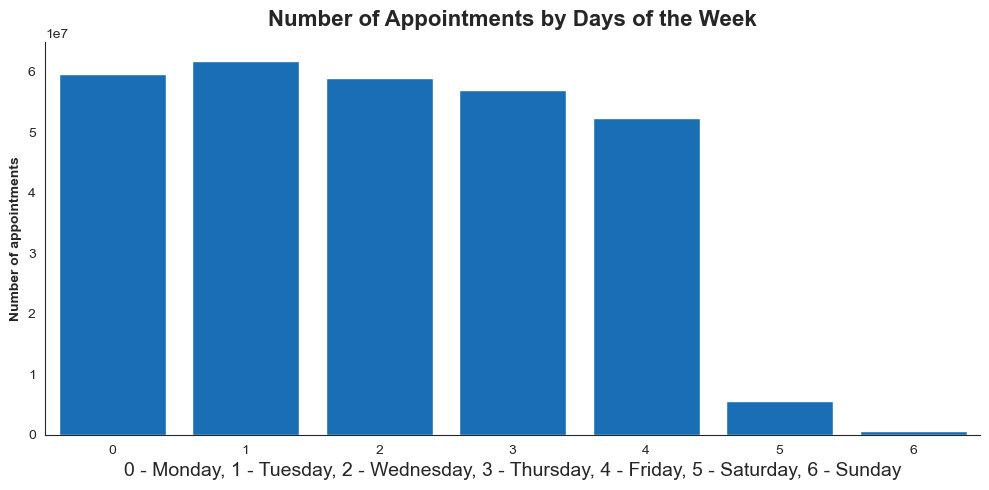

In [55]:
#Create a barplot to show apointments by day
nc_day = nc.groupby(['day_index','appointment_day'])['count_of_appointments'].sum().reset_index()

formatted_barplot(x='day_index',y='count_of_appointments',\
                  data=nc_day,color="#0072CE",title='Number of Appointments by Days of the Week',\
                  xlabel="0 - Monday, 1 - Tuesday, 2 - Wednesday, 3 - Thursday, 4 - Friday, 5 - Saturday, 6 - Sunday",\
                 ylabel='Number of appointments',xtick_rotation=0)

plt.savefig('apt by Days.png')


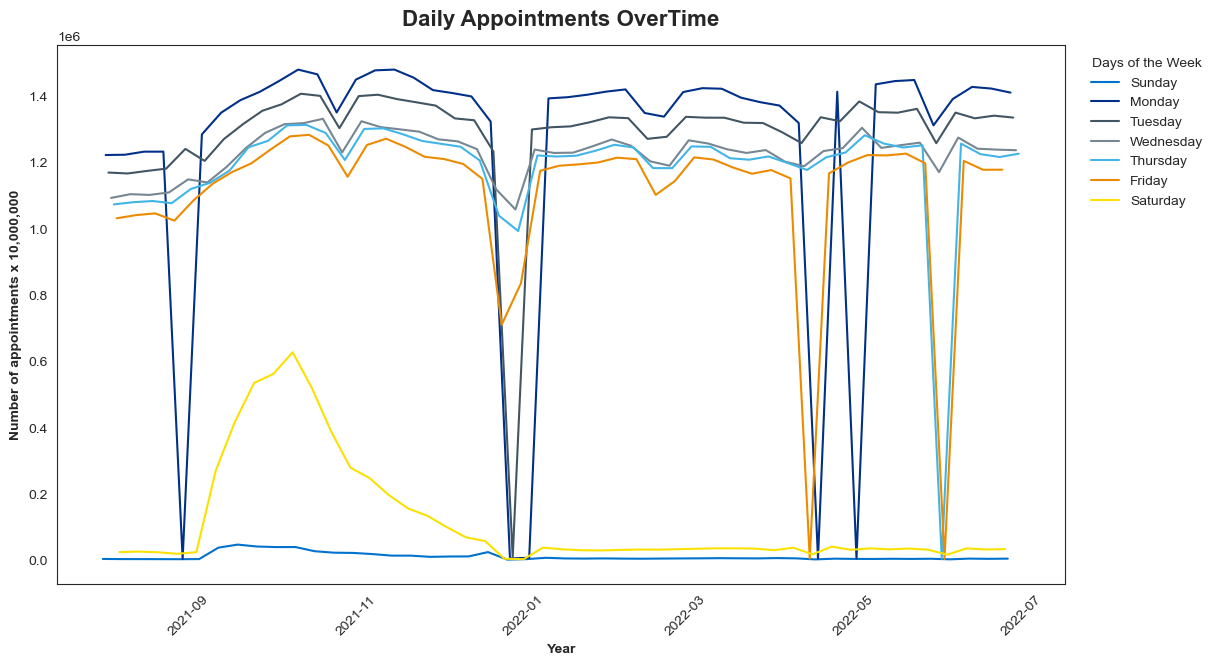

In [57]:
#Create a lineplot to show daily appointments overtime.
nc_daily = group_agg_sort_reset(nc,['appointment_date','appointment_day'],'count_of_appointments',sort=False,num_rows=None)

formatted_lineplot(data=nc_daily,x='appointment_date',y='count_of_appointments',
                   title='Daily Appointments OverTime',
                   hue='appointment_day',
                   xlabel ='Year',
                   ylabel = 'Number of appointments x 10,000,000',
                   xtick_rotation = 45,
                   legend_title='Days of the Week',
                  bbox=(1.15,1))
plt.savefig('daily apt.png')
nc_daily.to_csv('nc_daily.csv')

### Unlocked Daily Trends 
- Mondays had the highest numbers of appointments.
- Sudden boost in saturday appointment during 2021 autumn. 
- Visible dip in weekday appointment during 2021 autumn.

### 4.2 Monthly Trends

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


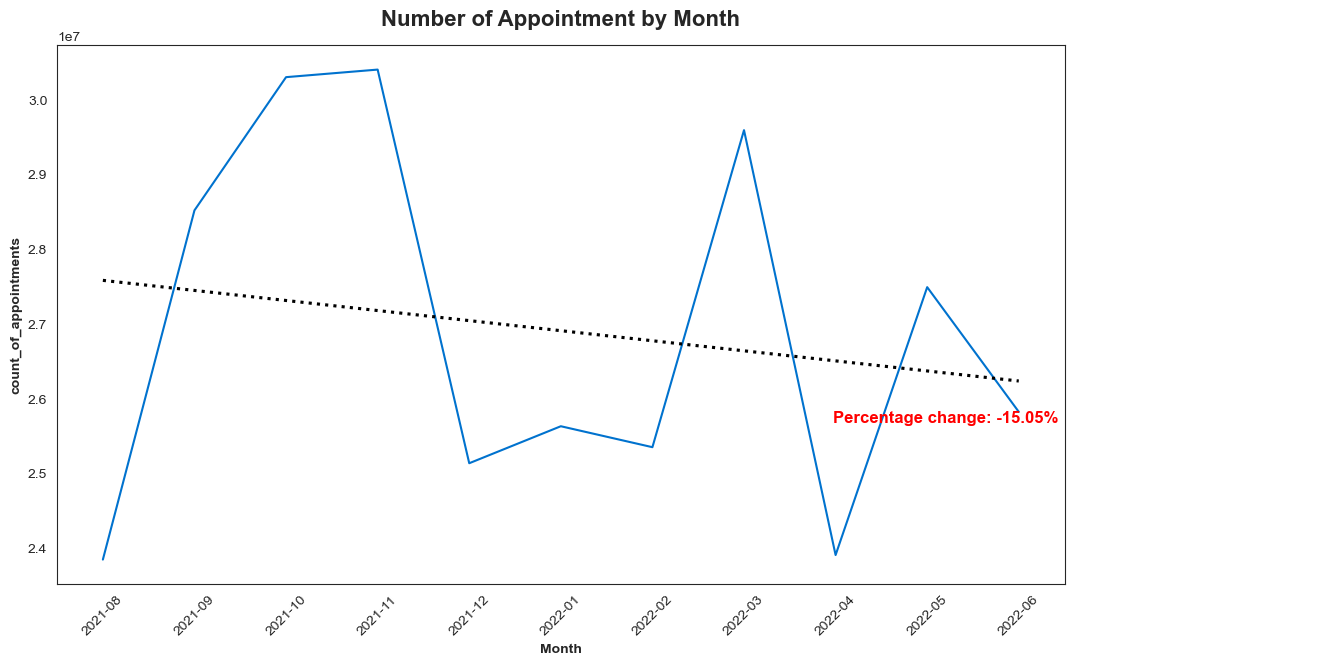

In [120]:
Monthly_apt = group_agg_sort_reset(nc,'appointment_month','count_of_appointments',sort=False,num_rows=None)
Monthly_apt['total%'] = percentage(Monthly_apt,'count_of_appointments',Total_Appt_nc)
# Create a lineplot.
formatted_lineplot(data=Monthly_apt,x='appointment_month',y='count_of_appointments',
                   title='Number of Appointment by Month',
                   xlabel ='Month',
                   ylabel = 'Number of appointments x 10,000,000',
                   xtick_rotation = 45,
                  hue=None,
                  legend_title=None)
# Draw trendline
sns.regplot(x=Monthly_apt.index.values, y='count_of_appointments', 
            data=Monthly_apt, scatter=False,ci=None,color='k',line_kws={'linestyle':'dotted'})

# Find the peak value
peak_value = Monthly_apt['count_of_appointments'].max()

# Calculate percentage change from peak to current value
current_value = Monthly_apt['count_of_appointments'].iloc[-1]
percentage_change = ((current_value - peak_value) / peak_value) * 100


# Annotate the plot with the percentage change
plt.text(0.77, 0.3, f'Percentage change: {percentage_change:.2f}%', transform=plt.gca().transAxes, fontsize=12,color='red',fontweight='bold')

plt.savefig('total_apt.png')

**Number of appointment for Service setting by month**
- GP Services has the highest number of appointment eventhough it is showing a downward trend.
- During December and April a sudden dip can be observed.


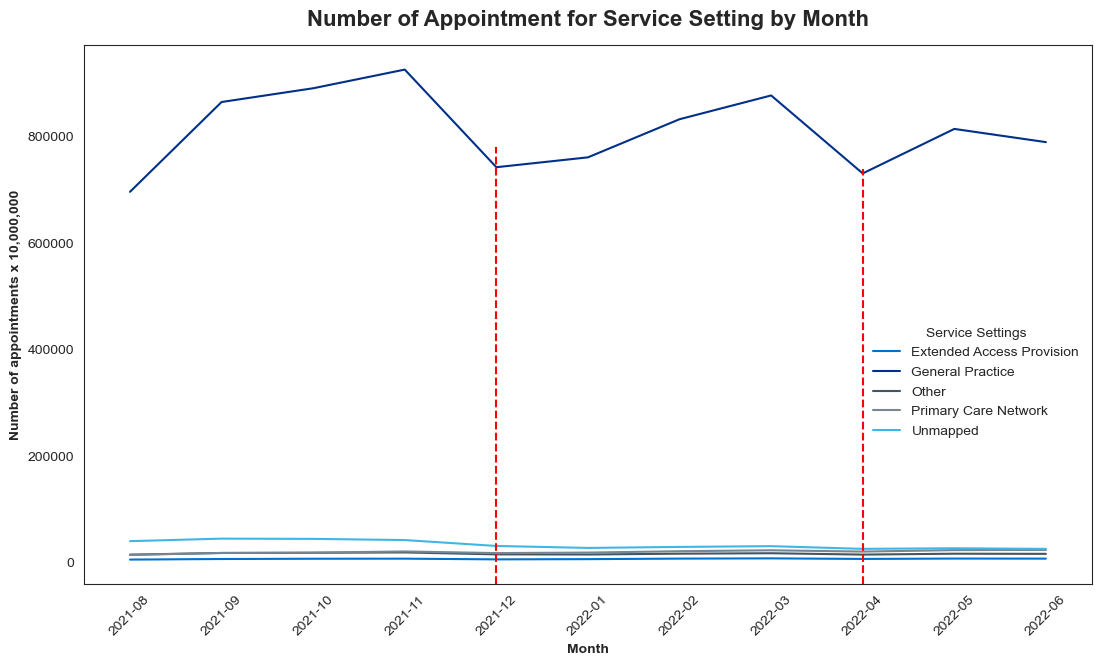

In [71]:
# Aggregate on a monthly level and determine the sum of records per month..
SS_monthly = group_agg_sort_reset(nc,['service_setting','appointment_month','appointment_date'],
                                  'count_of_appointments',sort=False,num_rows=None)
SS_monthly['total%'] = percentage(SS_monthly,'count_of_appointments',Total_Appt_nc)

# Create a lineplot.
formatted_lineplot(data=SS_monthly,x='appointment_month',y='count_of_appointments',
                   title='Number of Appointment for Service Setting by Month',
                   hue='service_setting',
                   xlabel ='Month',
                   ylabel = 'Number of appointments x 10,000,000',
                   xtick_rotation = 45,
                   legend_title='Service Settings',
                  bbox=(1,0.5))
#Highlight sudden dip in the graph
plt.axvline(x=('2021-12'),color='red',linestyle='--',ymax=0.81)
plt.axvline(x=('2022-04'),color='red',linestyle='--',ymax=0.77)

plt.savefig('ss_month.png')

**Number of appointment for context types by month**
There are only three types of context provided which limits the analysis. However care related encounters are high and lower inconsitent mapping and unmapped tells that good data quality and data entry.

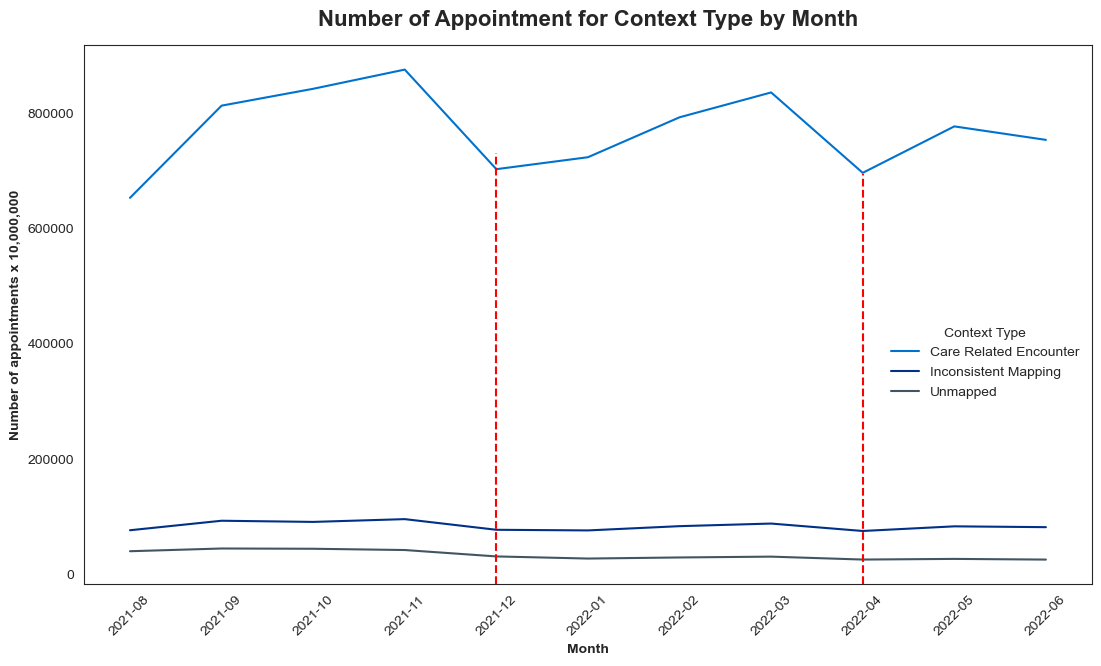

In [72]:
# Aggregate on a monthly level and determine the sum of records per month.
CT_Monthly = group_agg_sort_reset(nc,['context_type','appointment_month','appointment_date'],
                                  'count_of_appointments',sort=False,num_rows=None)
CT_Monthly['total%'] = percentage(CT_Monthly,'count_of_appointments',Total_Appt_nc)

# Create a lineplot.
formatted_lineplot(data=CT_Monthly,x='appointment_month',y='count_of_appointments',
                   title='Number of Appointment for Context Type by Month',
                   hue='context_type',
                   xlabel ='Month',
                   ylabel = 'Number of appointments x 10,000,000',
                   xtick_rotation = 45,
                   legend_title='Context Type',
                  bbox=(1,0.5))

#Highlight sudden dip in the graph
plt.axvline(x=('2021-12'),color='red',linestyle='--',ymax=0.8)
plt.axvline(x=('2022-04'),color='red',linestyle='--',ymax=0.76)

plt.savefig('CT_month.png')


In [66]:
CT_Monthly.groupby('context_type')['total%'].sum()

context_type
Care Related Encounter    86.80
Inconsistent Mapping       9.35
Unmapped                   3.35
Name: total%, dtype: float64

**Number of appointment for National categories by month**

<Figure size 2000x1500 with 0 Axes>

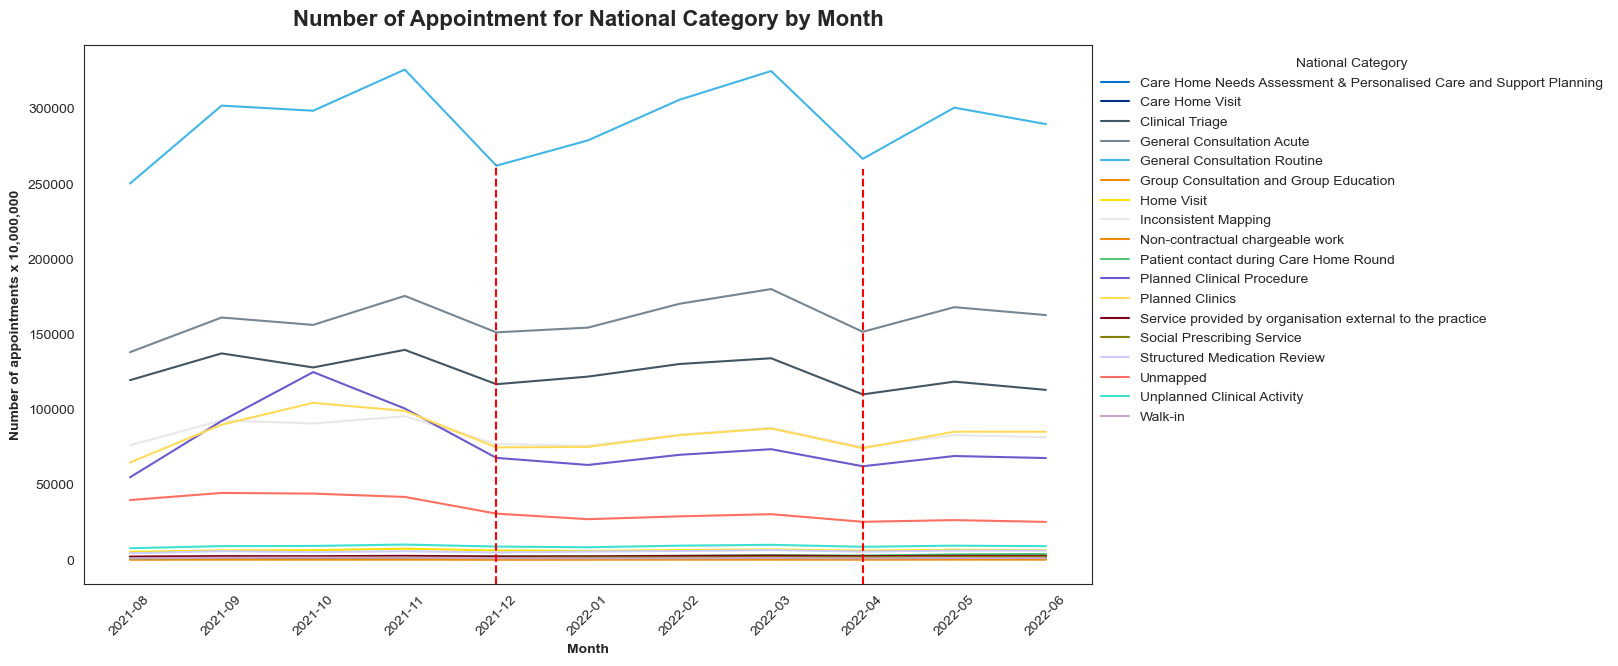

In [94]:
# Aggregate on a monthly level and determine the sum of records per month.

NC_Monthly = group_agg_sort_reset(nc,['national_category','appointment_month','appointment_date'],
                                  'count_of_appointments',sort=False,num_rows=None)

NC_Monthly['total%'] = percentage(NC_Monthly,'count_of_appointments',Total_Appt_nc)

# Create a lineplot.
plt.figure(figsize=(20,15))
formatted_lineplot(data=NC_Monthly,x='appointment_month',y='count_of_appointments',
                   title='Number of Appointment for National Category by Month',
                   hue='national_category',
                   xlabel ='Month',
                   ylabel = 'Number of appointments x 10,000,000',
                   xtick_rotation = 45,
                   legend_title='National Category',
                  bbox=(1.52,1))



#Highlight sudden dip in the graph
plt.axvline(x=('2021-12'),color='red',linestyle='--',ymax=0.78)           
plt.axvline(x=('2022-04'),color='red',linestyle='--',ymax=0.77)

plt.savefig('NC_month.png')

#### Trends and insights
- There's visible dip in all graphs during 2021 Decemeber and 2022 april. A further analysis needs to be done to investigate weather this is a seasonal trend.
- GP services undoubtedly seems to be the most popular service settings.
- General consulatations recorded as the highest national category speifically routine consultations.

### 4.3 Seasonal Trends

**Summer:**

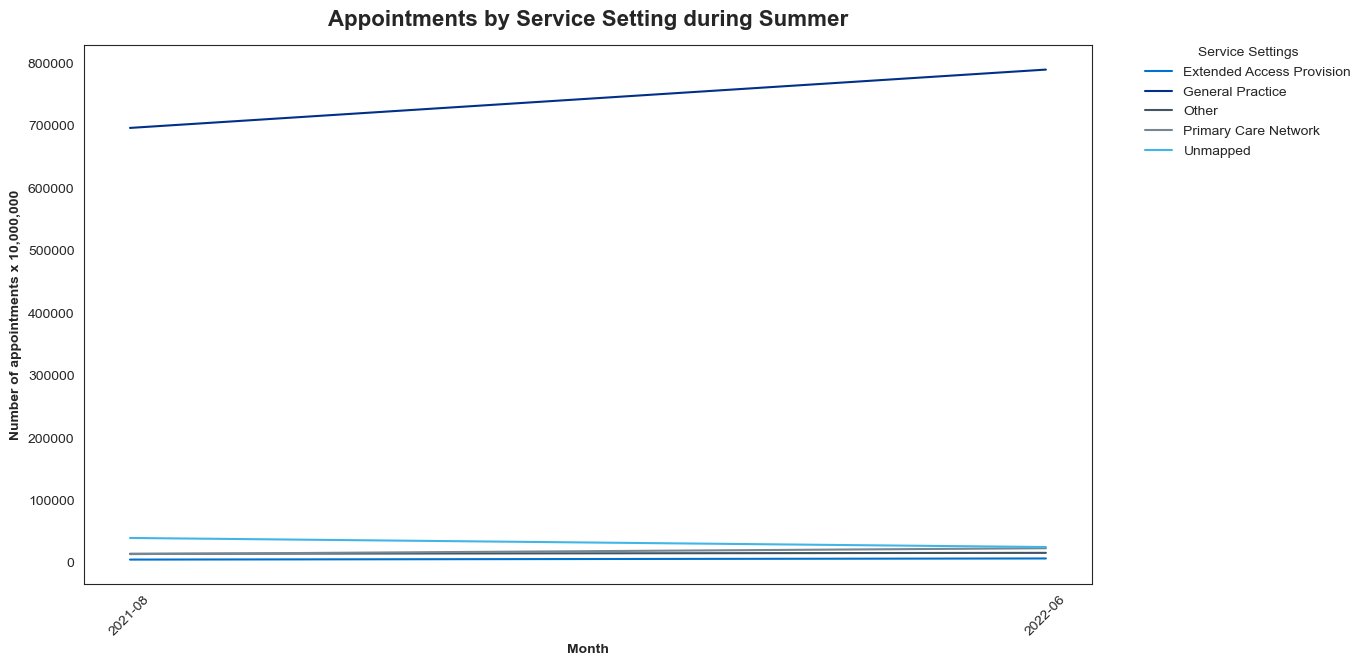

In [124]:
# Appointments by Service Setting during Summer
SS_summer = seasonal_data(SS_monthly,'appointment_month','summer')

# Visualise using a lineplot.
formatted_lineplot(x='appointment_month',
             y='count_of_appointments',
             hue='service_setting',
            data=SS_summer,
            title='Appointments by Service Setting during Summer',
            xlabel='Month',
            ylabel='Number of appointments x 10,000,000',
            legend_title='Service Settings',
            xtick_rotation=45)


**Autumn:**

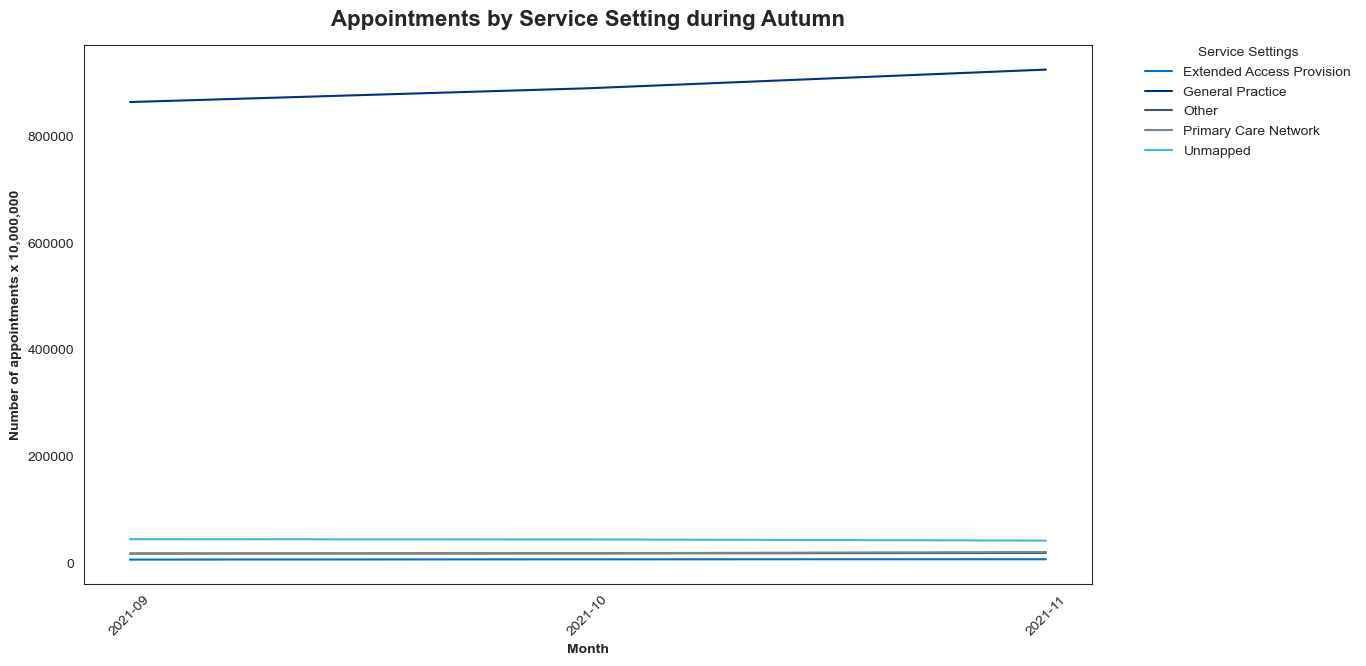

In [125]:
# Appointments by Service Setiings during Autumn.
SS_autumn = seasonal_data(SS_monthly,'appointment_month','Autumn')

# Visualise using a lineplot.
formatted_lineplot(x='appointment_month',
             y='count_of_appointments',
             hue='service_setting',
            data=SS_autumn,
            title='Appointments by Service Setting during Autumn',
            xlabel='Month',
            ylabel='Number of appointments x 10,000,000',
            legend_title='Service Settings',
            xtick_rotation=45)

**Winter:**

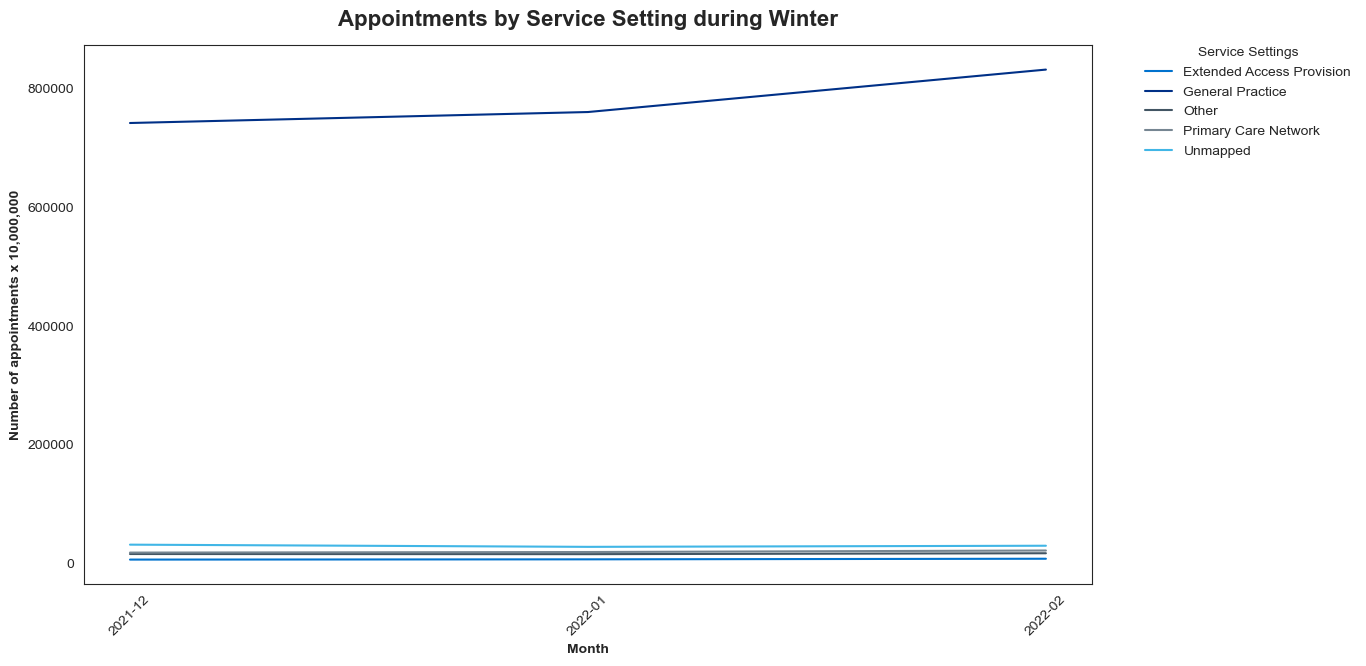

In [126]:
# Appointments by Service Setiings during Winter.

SS_winter = seasonal_data(SS_monthly,'appointment_month','Winter')

# Visualise using a lineplot.
formatted_lineplot(x='appointment_month',
             y='count_of_appointments',
             hue='service_setting',
            data=SS_winter,
            title='Appointments by Service Setting during Winter',
            xlabel='Month',
            ylabel='Number of appointments x 10,000,000',
            legend_title='Service Settings',
            xtick_rotation=45)

**Spring:**

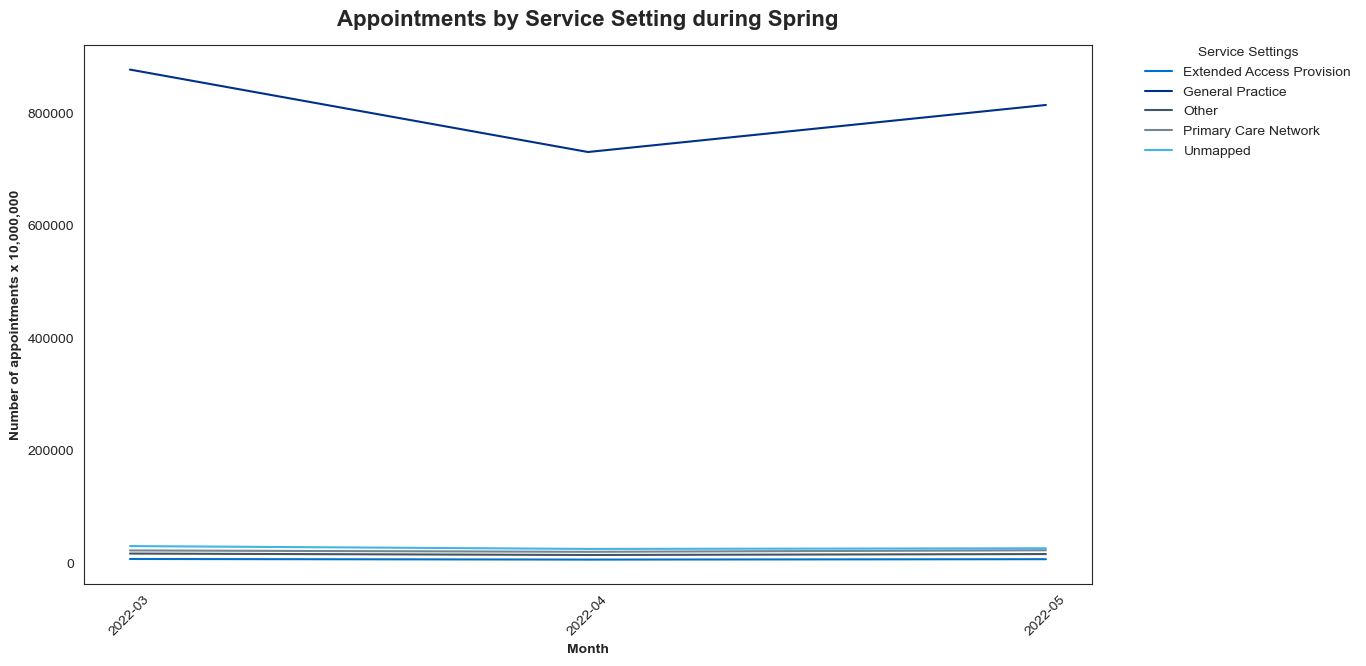

In [127]:
# Appointments by Service Setiings during Spring
# Used previously created DF
SS_spring = seasonal_data(SS_monthly,'appointment_month','Spring')

# Visualise using a lineplot.
formatted_lineplot(x='appointment_month',
             y='count_of_appointments',
             hue='service_setting',
            data=SS_spring,
            title='Appointments by Service Setting during Spring',
            xlabel='Month',
            ylabel='Number of appointments x 10,000,000',
            legend_title='Service Settings',
            xtick_rotation=45)

## Addressing main concerns

In [128]:
# Filter the data set to only look at data from 2021-08 onwards.
ar_2 = ar[ar['appointment_month']>'2021-08']
ar_2.head()

,icb_ons_code,appointment_month,appointment_status,hcp_type,appointment_mode,time_between_book_and_appointment,count_of_appointments,icb_location_name,region_name
3850,E54000034,2021-09,Attended,GP,Face-to-Face,1 Day,8288,NHS Frimley ICB,South East
3851,E54000034,2021-09,Attended,GP,Face-to-Face,15 to 21 Days,3827,NHS Frimley ICB,South East
3852,E54000034,2021-09,Attended,GP,Face-to-Face,2 to 7 Days,13466,NHS Frimley ICB,South East
3853,E54000034,2021-09,Attended,GP,Face-to-Face,22 to 28 Days,1300,NHS Frimley ICB,South East
3854,E54000034,2021-09,Attended,GP,Face-to-Face,8 to 14 Days,6825,NHS Frimley ICB,South East


**Question 1:** Should the NHS start looking at increasing staff levels? 

**Answer 1:**
No, current work load is within the capacity hence no need to increase the staff levels.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


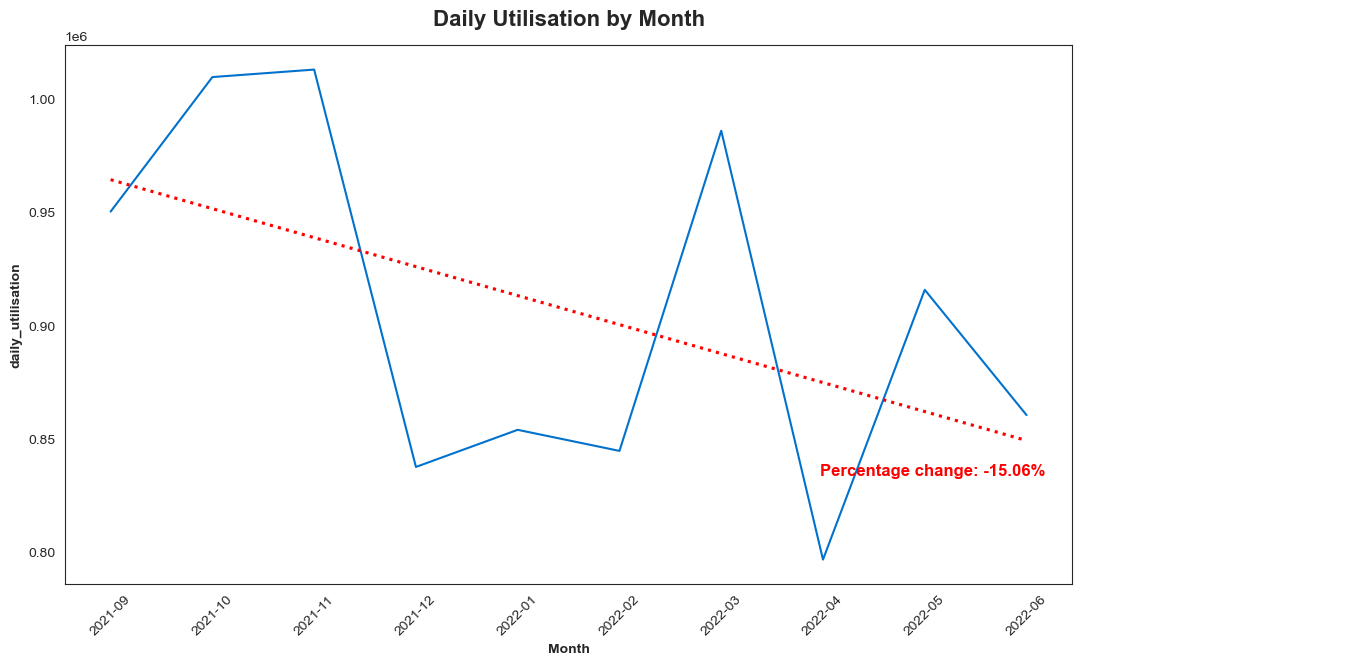

In [129]:
# Create an aggregated data set to review the different features.
ar_agg = group_agg_sort_reset(ar_2,['appointment_month','hcp_type','appointment_status',\
                       'appointment_mode','time_between_book_and_appointment'],
                              'count_of_appointments',num_rows=None,sort=False)

# Determine the total number of appointments per month.
ar_df = group_agg_sort_reset(ar_agg,'appointment_month','count_of_appointments',num_rows=None,sort=False)

# Add a new column to indicate the average utilisation of services.
# Monthly aggregate / 30 to get to a daily value.
ar_df['daily_utilisation'] = (ar_df['count_of_appointments']/30).round(1)

# View the DataFrame.
ar_df.head()

# Daily Utilisation by Month
formatted_lineplot(x='appointment_month',y='daily_utilisation',
                  data=ar_df,title='Daily Utilisation by Month',
                 ylabel='Daily Utilisation x10,000,000',
                 xlabel='Month',
                 xtick_rotation=45,
                  hue=None,
                  legend_title=None)

# Draw trendline
sns.regplot(x=ar_df.index.values, y='daily_utilisation', 
            data=ar_df, scatter=False,ci=None,color='red',line_kws={'linestyle':'dotted'})

# Find the peak value
peak_value = ar_df['daily_utilisation'].max()

# Calculate percentage change from peak to current value
current_value = ar_df['daily_utilisation'].iloc[-1]
percentage_change = ((current_value - peak_value) / peak_value) * 100


# Annotate the plot with the percentage change
plt.text(0.75, 0.2, f'Percentage change: {percentage_change:.2f}%', transform=plt.gca().transAxes, fontsize=12,color='red',fontweight='bold')

plt.savefig('Daily Utilisation.png')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


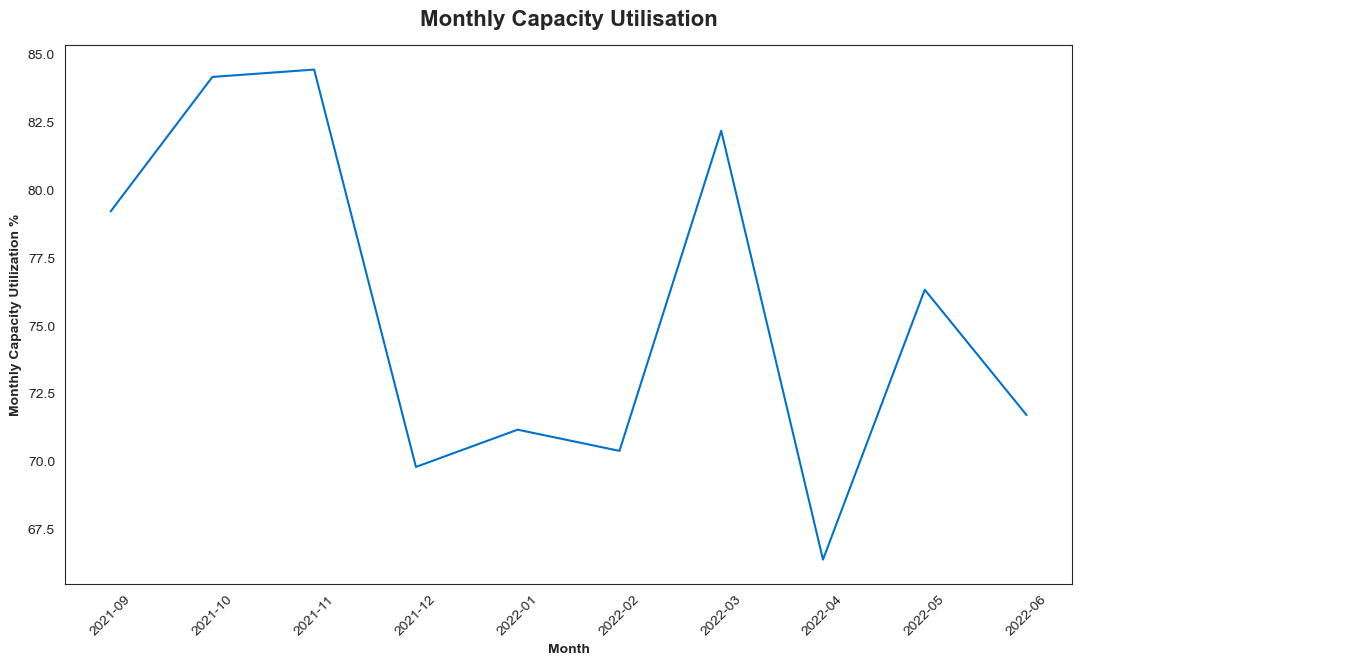

In [130]:
# Add a column to the dataframe to show the monthly utilisation.
ar_df['monthly_cap_utilisation'] = ((ar_df['count_of_appointments']/(1200000*30))*100).round(2)


# Plot monthly capacity utilisation.
formatted_lineplot(x='appointment_month',y='monthly_cap_utilisation',
                  data=ar_df,
                title='Monthly Capacity Utilisation',
                 ylabel='Monthly Capacity Utilization %',
                 xlabel='Month',
                 xtick_rotation=45,
                  hue=None,
                  legend_title=None)
plt.savefig('Monthly Utilisation.png')

**Question 2:** How do the healthcare professional types differ over time?
    
**Answer 2:**
GP services seems to be the popular services over time however during 2021 October other GP services peaked. 

Eventhogh GP services are popluar now comparing to 2021 lower in the number of appoitnments.

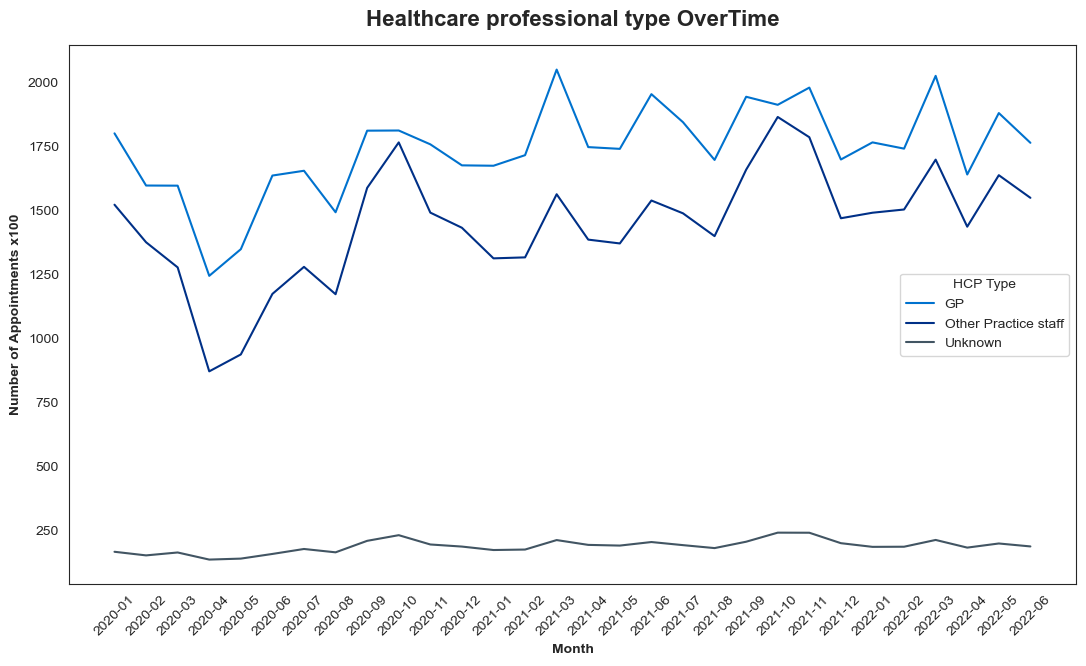

In [131]:
# Create a lineplot to answer the question.
formatted_lineplot(x='appointment_month',y='count_of_appointments',
                  data=ar,
                title='Healthcare professional type OverTime',
                 ylabel='Number of Appointments x100',
                 xlabel='Month',
                 xtick_rotation=45,
                  hue='hcp_type',
                  legend_title="HCP Type",
                  loc='center right',
                  bbox=None,
                  frameon=True)

plt.savefig('HCPT.png')

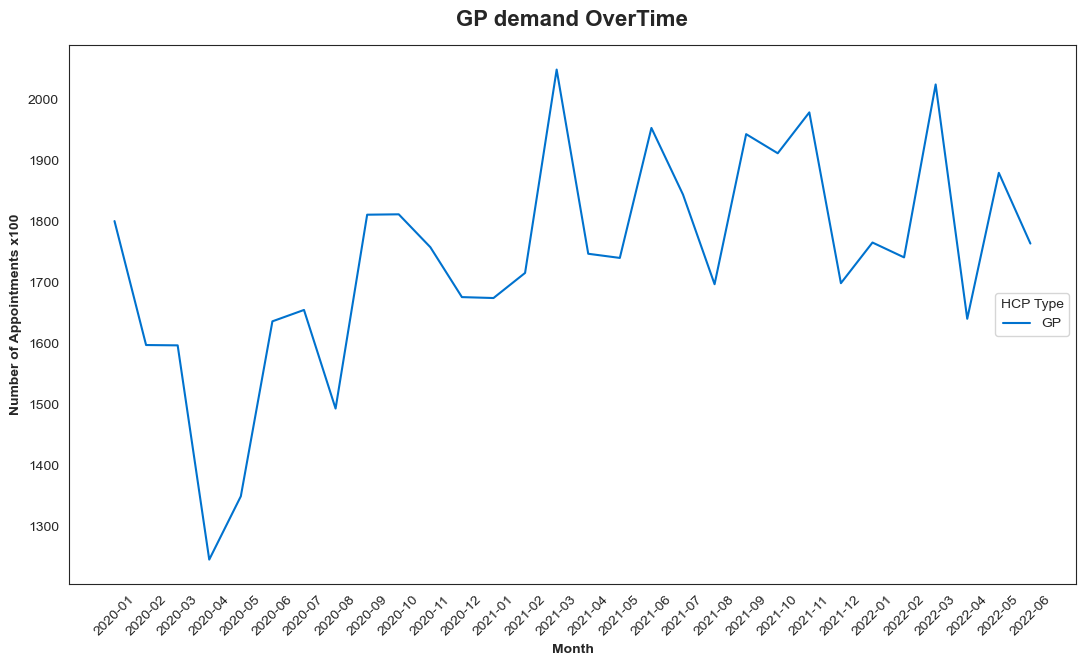

In [132]:
#Looking at GP alone
GP = ar[ar['hcp_type']=='GP']
# Create a lineplot to answer the question.
formatted_lineplot(x='appointment_month',y='count_of_appointments',
                  data=GP,
                title='GP demand OverTime',
                 ylabel='Number of Appointments x100',
                 xlabel='Month',
                 xtick_rotation=45,
                  hue='hcp_type',
                  legend_title="HCP Type",
                  loc='center right',
                  bbox=None,
                  frameon=True)

**Question 3:** Are there significant changes in whether or not visits are attended?

**Answer 3:**
Not attendended and status unknown appointments are gardually decreasing however this could be due to the fact that total number appointments has reduced compared to 2021.
Postive side of the appointment status are majority of them are attended.

In [133]:
ar.dtypes

icb_ons_code                         object
appointment_month                    object
appointment_status                   object
hcp_type                             object
appointment_mode                     object
time_between_book_and_appointment    object
count_of_appointments                 int64
icb_location_name                    object
region_name                          object
dtype: object

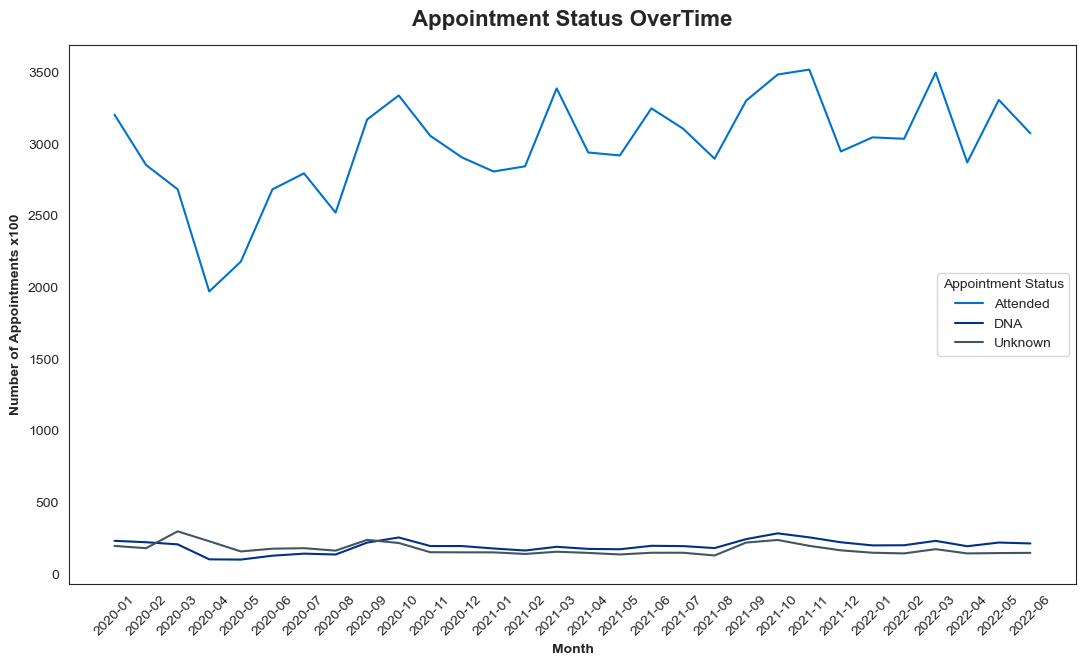

In [134]:
# Create a lineplot to answer the question.
formatted_lineplot(x='appointment_month',y='count_of_appointments',
                  data=ar,
                title='Appointment Status OverTime',
                 ylabel='Number of Appointments x100',
                 xlabel='Month',
                 xtick_rotation=45,
                  hue='appointment_status',
                  legend_title="Appointment Status",
                  loc='center right',
                  bbox=None,
                  frameon=True)

plt.savefig('apt stat.png')

**Question 4:** Are there changes in terms of appointment type and the busiest months?

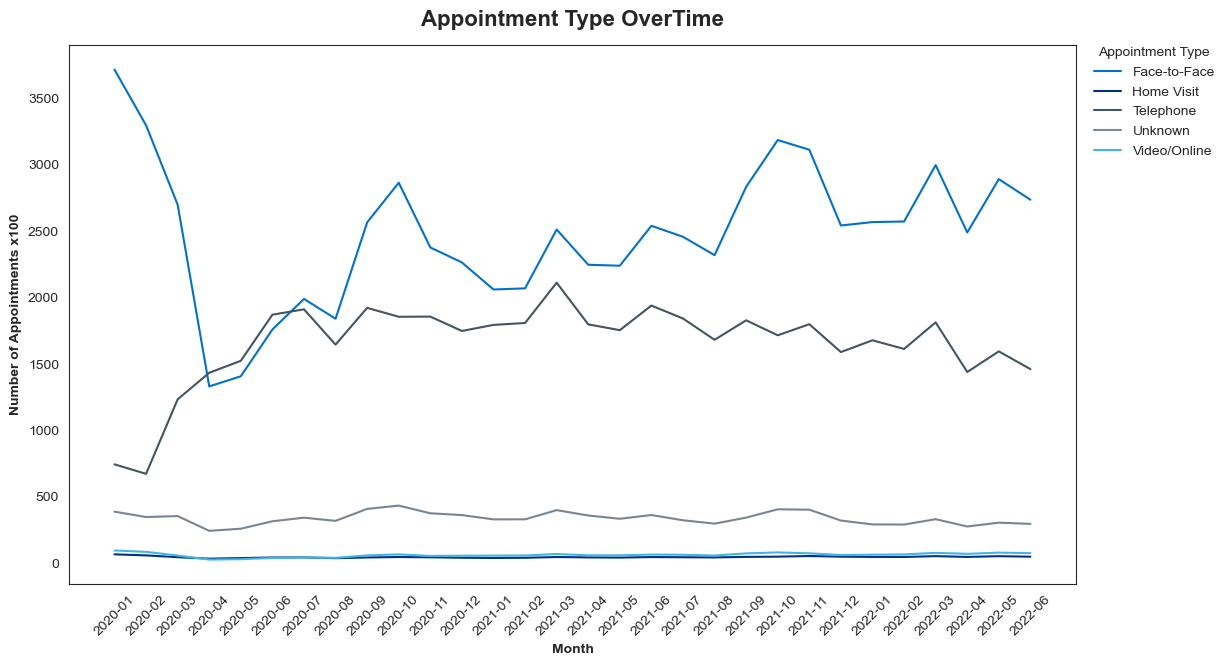

In [135]:
# Create a lineplot to answer the question.
formatted_lineplot(x='appointment_month',y='count_of_appointments',
                  data=ar,
                title='Appointment Type OverTime',
                 ylabel='Number of Appointments x100',
                 xlabel='Month',
                 xtick_rotation=45,
                  hue='appointment_mode',
                  legend_title="Appointment Type",
                  bbox=(1.15,1.02))

plt.savefig('apt type.png')

**Question 5:** Are there any trends in time between booking an appointment?

**Answer 5:**
Efficient booking system was evident from the graph.Most of the appointment was booked within 2 weeks. 
Majority of the appointment were made on the same day.

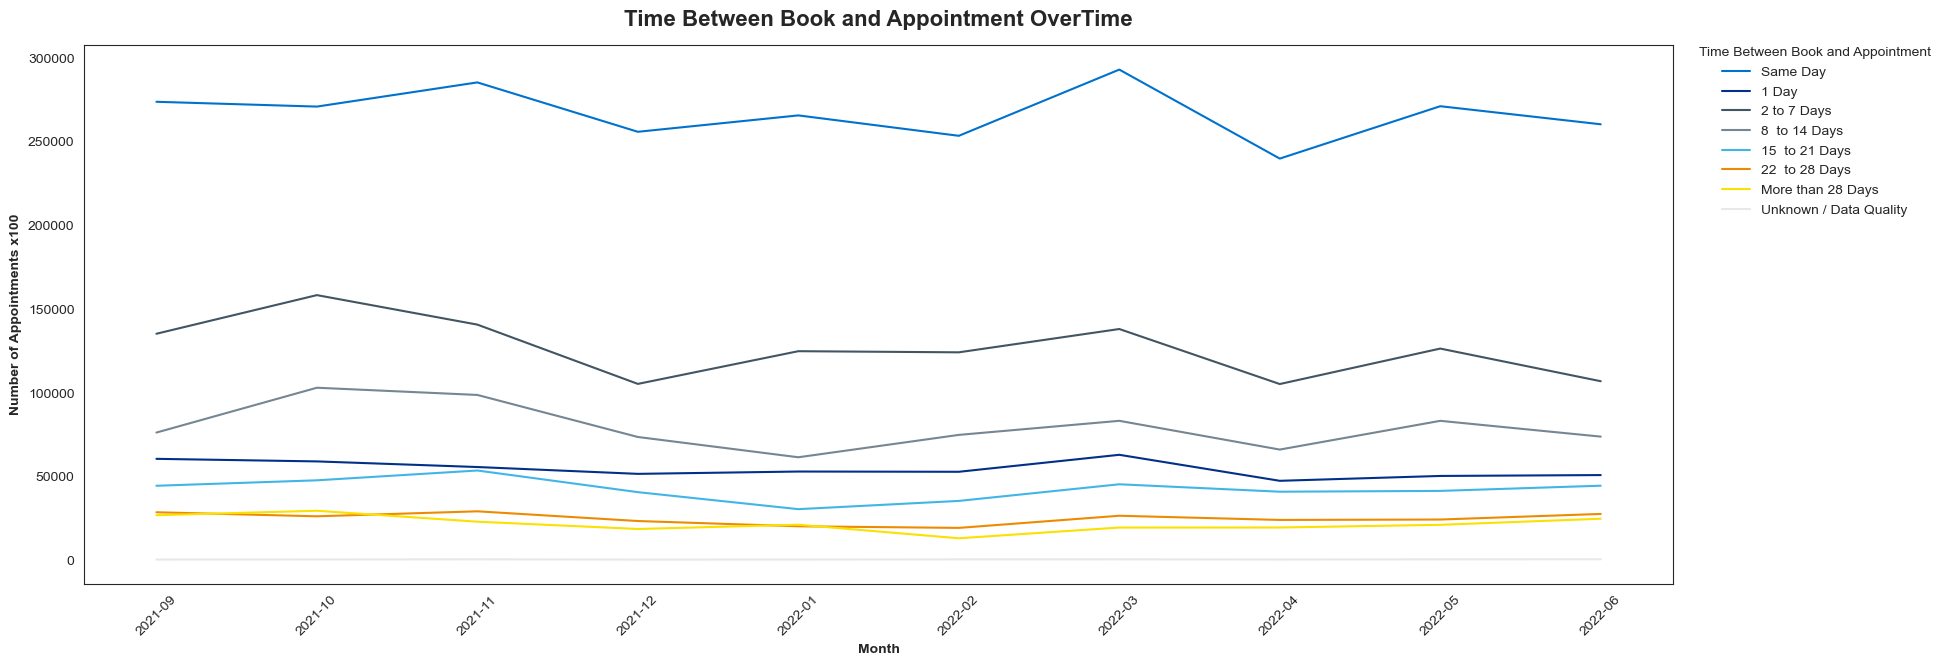

In [136]:
# Define the order of categories for the 'service_category' column
hue_order = ['Same Day', '1 Day', '2 to 7 Days','8  to 14 Days','15  to 21 Days','22  to 28 Days','More than 28 Days','Unknown / Data Quality']

# Lineplot
formatted_lineplot(x='appointment_month',y='count_of_appointments',
                  data=ar_agg,
                title='Time Between Book and Appointment OverTime',
                 ylabel='Number of Appointments x100',
                 xlabel='Month',
                 xtick_rotation=45,
                  hue='time_between_book_and_appointment',
                  hue_order= hue_order,
                  legend_title='Time Between Book and Appointment',
                  bbox=(1.17,1.02),
                  figsize=(20.5,7))

plt.savefig('bookings.png')

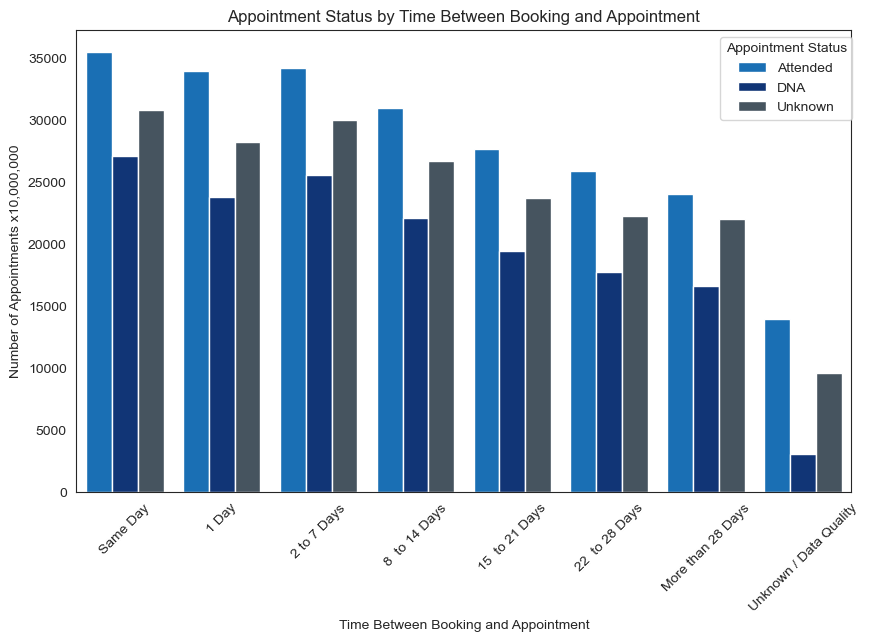

In [99]:
# Appointment status vs Time Between Booking and Appointment

#Set up the figure
plt.figure(figsize=(10, 6))

# Plot a stacked bar chart
xlabel_order = ['Same Day', '1 Day', '2 to 7 Days','8  to 14 Days','15  to 21 Days','22  to 28 Days','More than 28 Days','Unknown / Data Quality']
sns.countplot(data=ar, x='time_between_book_and_appointment', hue='appointment_status',order=xlabel_order)

# Add labels and title
plt.xlabel('Time Between Booking and Appointment')
plt.ylabel('Number of Appointments x10,000,000')
plt.title('Appointment Status by Time Between Booking and Appointment')
plt.xticks(rotation=45)

# Add a legend
plt.legend(title='Appointment Status',bbox_to_anchor = (1.01,1))

plt.savefig('dna1.png')

**Question 6:** How does the spread of service settings compare?

**Answer 6:**
GP services proved to be the highest and most popular services. stays unchanged.Eventhough fluctuated remains on the top.
unmapped records are high,however reduced overtime signalling data receiving quality has increased.

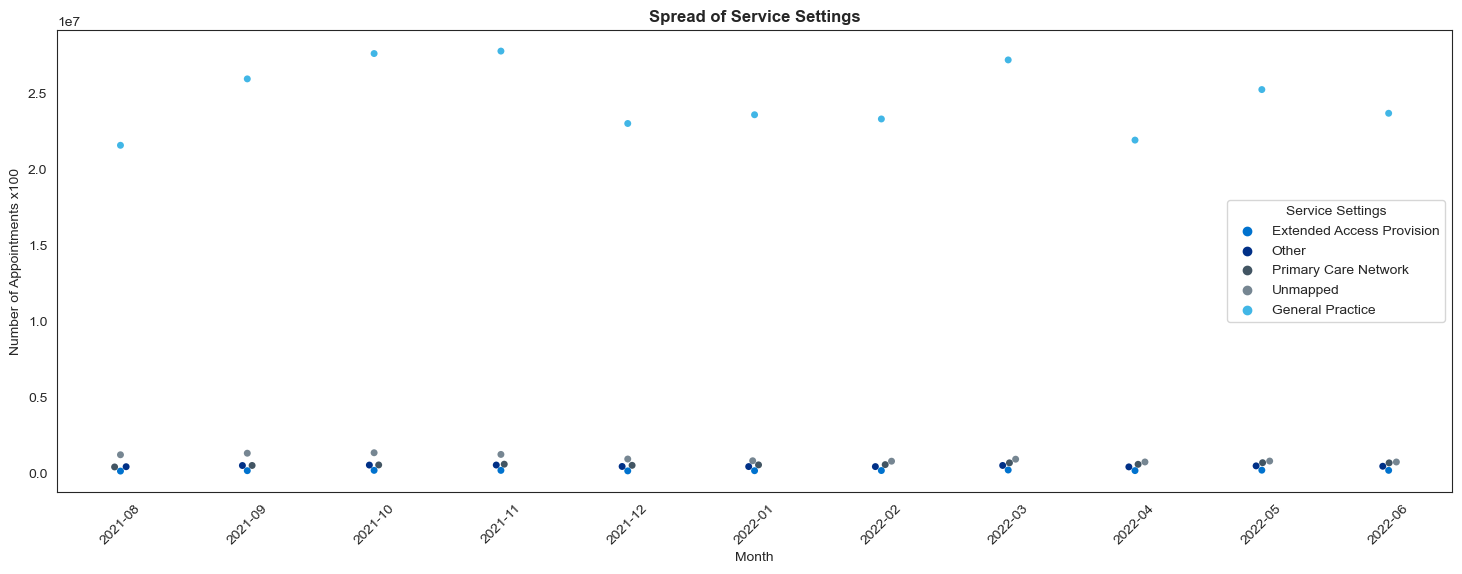

In [138]:
# Create a new DataFrame consisting of the month of appointment and the number of appointments.
nc_ss = group_agg_sort_reset(nc,['service_setting','appointment_month'],
                             'count_of_appointments',sort=False,num_rows=None)\
                            .sort_values('appointment_month')\
                            .rename(columns={'count_of_appointments': 'total appointments'})
                                    
nc_ss['total%'] = percentage(nc_ss,'total appointments',Total_Appt_nc)
nc_ss = nc_ss[['appointment_month','service_setting','total appointments','total%']]

# Create a swarmplot to investigate the spread of service settings.
plt.figure(figsize=(18,6))
sns.swarmplot(x='appointment_month',y='total appointments',hue='service_setting',data=nc_ss)

plt.title('Spread of Service Settings',fontweight='bold')
plt.ylabel('Number of Appointments x100')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.legend(loc='center right',title='Service Settings')

plt.savefig('ss spread.png')

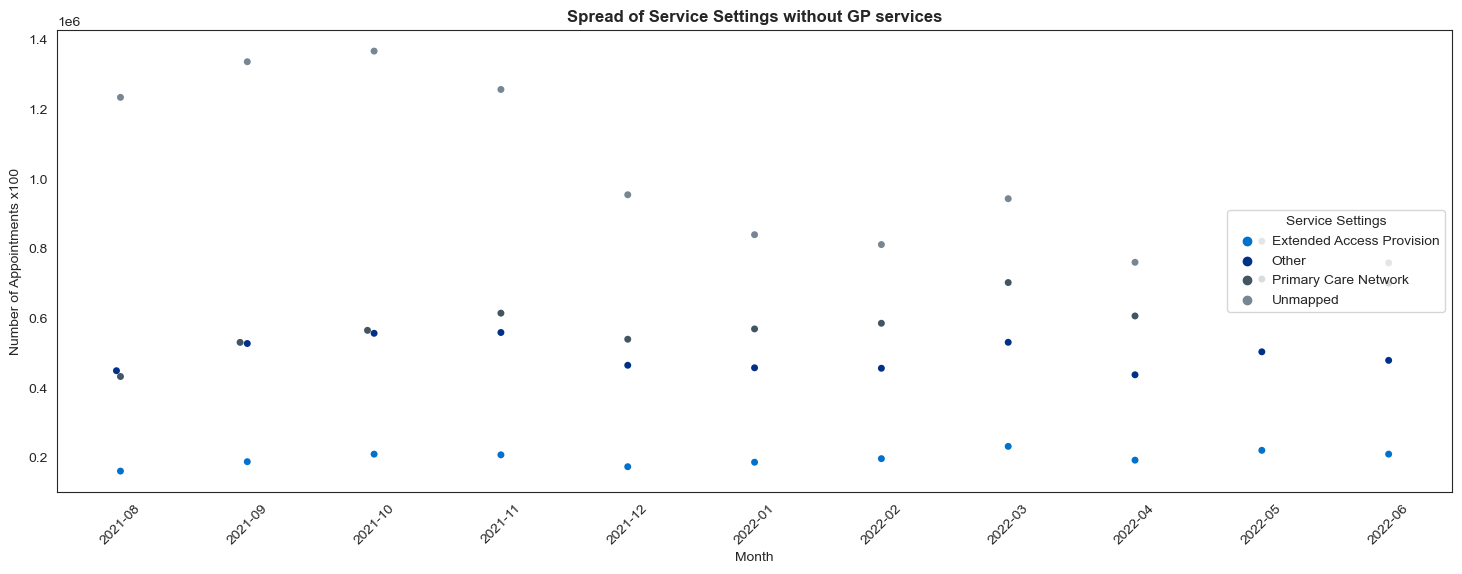

In [139]:
# Create a swarmplot to investigate the service settings without GP.
plt.figure(figsize=(18,6))
sns.swarmplot(x='appointment_month',y='total appointments',
              hue='service_setting',data=nc_ss[nc_ss['service_setting']!='General Practice'])

plt.title('Spread of Service Settings without GP services',fontweight='bold')
plt.ylabel('Number of Appointments x100')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.legend(loc='center right',title='Service Settings')

plt.savefig('ss wtgp.png')

### Twitter Aata Analysis (Paused)

>Analyse tweets from Twitter with hashtags related to healthcare in the UK.

In [140]:
# Set the figure size.
sns.set(rc={'figure.figsize':(15, 12)})

# Set the plot style as white.
sns.set_style('white')

# Maximum column width to display.
pd.options.display.max_colwidth = 200

In [141]:
# Would it be useful to only look at retweeted and favourite tweet messages?
# Explain your answer.
tweets['tweet_retweet_count'].value_counts()

tweet_retweet_count
0      526
1      215
2      114
3       70
5       35
4       27
7       18
12      16
8       15
73      14
9       13
6       12
208     12
35      10
37       6
11       6
10       5
53       5
44       4
150      4
63       4
76       3
85       3
41       3
62       3
207      3
68       3
78       2
23       2
24       2
72       2
16       2
13       1
49       1
48       1
15       1
107      1
14       1
79       1
20       1
39       1
19       1
303      1
57       1
40       1
54       1
169      1
Name: count, dtype: int64

In [142]:
tweets['tweet_favorite_count'].value_counts()

tweet_favorite_count
0     1027
1       91
2       16
3       13
4        7
5        5
6        2
17       1
12       1
10       1
8        1
13       1
11       1
7        1
20       1
28       1
14       1
18       1
9        1
42       1
Name: count, dtype: int64

In [143]:
# Create a new DataFrame containing only the text.
tweets_text = tweets[['tweet_full_text', 'tweet_entities',
       'tweet_entities_hashtags', 'tweet_lang']]

# View the DataFrame.
tweets_text.head()

,tweet_full_text,tweet_entities,tweet_entities_hashtags,tweet_lang
0,"As Arkansas’ first Comprehensive Stroke Certified Center, UAMS provides Arkansans with access to the most advanced stoke care. Join us in our mission to make a difference in the health and well-be...","{'hashtags': [{'text': 'Healthcare', 'indices': [253, 264]}], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/yw0cstfmSI', 'expanded_url': 'https://bit.ly/3BiSKbs', 'display_url...",#Healthcare,en
1,RT @AndreaGrammer: Work-life balance is at the foundation of how decisions are made and where #PremiseHealth is headed. We're #hiring for…,"{'hashtags': [{'text': 'PremiseHealth', 'indices': [94, 108]}, {'text': 'hiring', 'indices': [127, 134]}], 'symbols': [], 'user_mentions': [{'screen_name': 'AndreaGrammer', 'name': 'Andrea Grammer...","#PremiseHealth, #hiring",en
2,RT @OntarioGreens: $10 billion can go a long way to fixing our broken #Healthcare system.\n\nYet Doug Ford would rather spend it ALL on a hig…,"{'hashtags': [{'text': 'Healthcare', 'indices': [70, 81]}], 'symbols': [], 'user_mentions': [{'screen_name': 'OntarioGreens', 'name': 'Green Party of Ontario', 'id': 37115912, 'id_str': '37115912'...",#Healthcare,en
3,RT @modrnhealthcr: 🚨#NEW:🚨 Insurance companies are figuring out the best ways to collect information about members’ race and ethnicity data…,"{'hashtags': [{'text': 'NEW', 'indices': [20, 24]}], 'symbols': [], 'user_mentions': [{'screen_name': 'modrnhealthcr', 'name': 'Modern Healthcare', 'id': 18935711, 'id_str': '18935711', 'indices':...",#NEW,en
4,"ICYMI: Our recent blogs on Cybersecurity in Accounting https://t.co/4nnK0FiVVL and Digital Transformation in Healthcare Finance https://t.co/jIqn52lHD3 are a great read, take a look!\n\n#blogs #di...","{'hashtags': [{'text': 'blogs', 'indices': [184, 190]}, {'text': 'digitaltransformation', 'indices': [191, 213]}, {'text': 'cybersecurity', 'indices': [214, 228]}, {'text': 'accounting', 'indices'...","#blogs, #digitaltransformation, #cybersecurity, #accounting, #finance, #healthcare",en


In [144]:
# Loop through the messages, and create a list of values containing the # symbol.
tags=[]
for y in [x.split(' ') for x in tweets['tweet_full_text'].values]:
    for z in y:
        if '#' in z:
            # Change to lowercase.
            tags.append(z.lower())
#Create a Pandas Series to count the values in the list            
tag_series = pd.Series(tags)

# Convert the series to a DataFrame in preparation for visualisation.
tag_count = tag_series.value_counts().reset_index()

# Rename the columns.
tag_count.columns=['word','count']

# Display the first 30 records.
tag_count.head(30)

,word,count
0,#healthcare,716
1,#health,80
2,#medicine,41
3,#ai,40
4,#job,38
5,#medical,35
6,#strategy,30
7,#pharmaceutical,28
8,#digitalhealth,25
9,#pharma,25


In [145]:
#View dtypes
tag_count.dtypes

word     object
count     int64
dtype: object

In [146]:
# Sense check the dataframe
print(tag_count.shape)
print(tag_count.describe())
print(tag_count.info())

(1754, 2)
             count
count  1754.000000
mean      2.470353
std      17.462844
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max     716.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754 entries, 0 to 1753
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    1754 non-null   object
 1   count   1754 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 27.5+ KB
None


In [147]:
# Display records where the count is larger than 10.
tag_count_10 = tag_count['count']<10
tag_count_10

0       False
1       False
2       False
3       False
4       False
        ...  
1749     True
1750     True
1751     True
1752     True
1753     True
Name: count, Length: 1754, dtype: bool

Text(0.5, 0, 'Frequency')

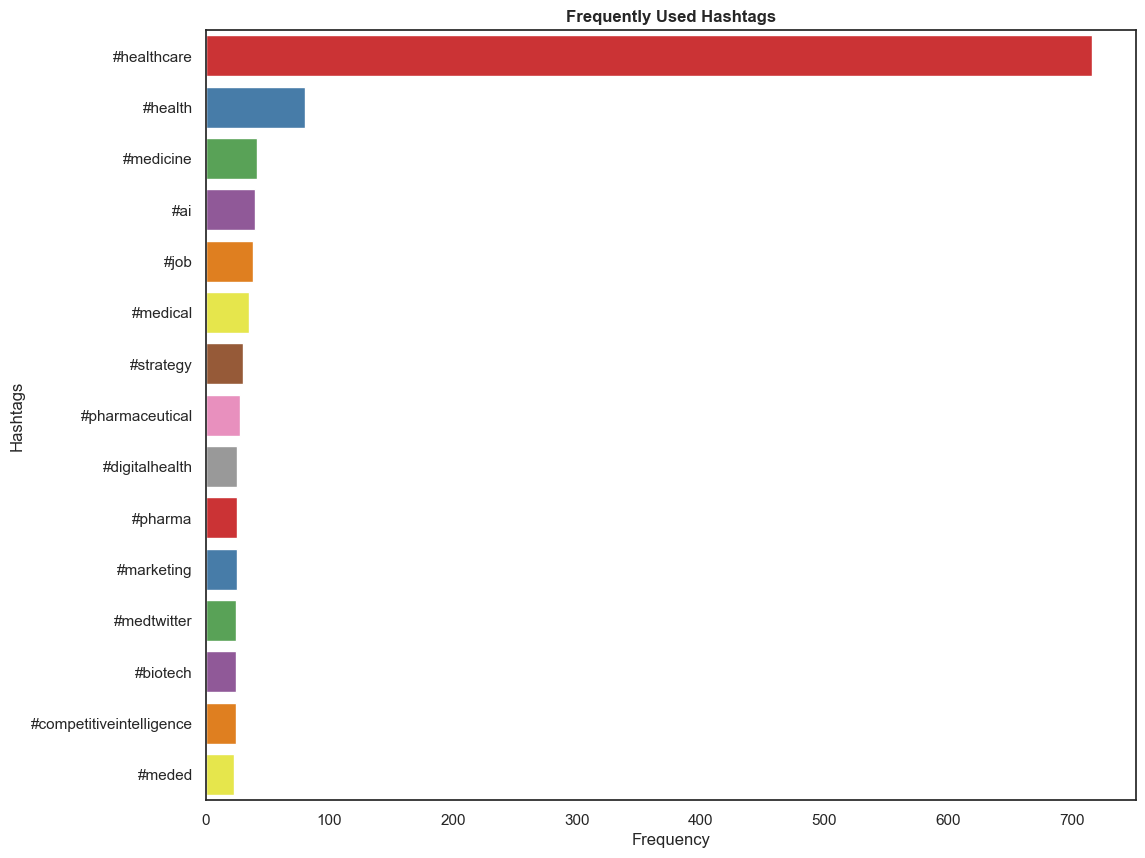

In [148]:
# Create a Seaborn barplot displaying records with a count larger than 20.
plt.figure(figsize=(12,10))
sns.barplot(x='count',y='word',palette='Set1',data=tag_count[tag_count['count']>20])

# Formatting
plt.title('Frequently Used Hashtags',fontweight='bold')
plt.ylabel('Hashtags',fontsize=12)
plt.xlabel('Frequency',fontsize=12)